___

# <p style="text-align: center"> Invisible Influencers </p>
## <p style="text-align: center"> Investigating YouTube Bot's Phenomenon </p>

___

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import pickle
import random
import gzip
import json
import zstd
import polars as pl
import time
import glob
import plotly.express as px
pio.kaleido.scope.plotlyjs = None
import plotly.io as pio
from scipy.stats import gaussian_kde
import plotly.graph_objects as go
from sklearn.svm import SVC
import os
from math import pi
from PIL import Image
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import make_interp_spline
from datetime import datetime
from tqdm import tqdm

In [ ]:
# Set Default Plotting Params
font_family = "Arial"
plt.rcParams["font.family"] = font_family

# Optional: Set font size and weight
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

# Apply Seaborn theme (inherits Matplotlib fonts)
sns.set_theme(style="whitegrid", font=font_family)

# Apply Plotly theme
plotly_layout = {
    "font": {
        "family": font_family,
        "size": 12,  # Match with plt.rcParams["font.size"]
    }
}

#### - **Data Loading**

In [4]:
combine = False
if combine:
    datasets = ['normal', 'suspicious']
    for dataset in datasets:
        print(f"reading partial files '{dataset}_i.parquet'...")
        parquet_files = glob.glob(f'./data_type1/{dataset}_users_*.parquet')
        
        # Read and concatenate all Parquet files
        combined = pl.concat([pl.read_parquet(file) for file in parquet_files])
        combined.write_parquet(f'data_type1/combi_{dataset}_dataset1.parquet')

In [5]:
# Load Data
type_1=pl.read_parquet('data/data_type1/combi_dataset1.parquet')
df_sus=pl.read_parquet('data/data_type1/combi_suspicious_dataset1.parquet')

In [5]:
#Load  normal users:
type_1=pl.read_parquet('data/data_type1/combi_dataset1.parquet')

#Load suspicious users:
df_sus=pl.read_parquet('data/data_type1/combi_suspicious_dataset1.parquet')

# Add a column 'year' to the dataframe
df_sus = df_sus.with_columns([
    pl.col("upload_date").cast(pl.Date),  
    pl.col("upload_date").dt.year().alias("year")
])
df_sus

shape: (18_891_930, 13)
┌───────────┬─────────────┬──────────┬───────┬───┬────────────┬─────────────┬─────────────┬──────┐
│ author    ┆ video_id    ┆ comments ┆ likes ┆ … ┆ like_count ┆ upload_date ┆ view_count  ┆ year │
│ ---       ┆ ---         ┆ ---      ┆ ---   ┆   ┆ ---        ┆ ---         ┆ ---         ┆ ---  │
│ i64       ┆ str         ┆ u32      ┆ i64   ┆   ┆ f64        ┆ date        ┆ f64         ┆ i32  │
╞═══════════╪═════════════╪══════════╪═══════╪═══╪════════════╪═════════════╪═════════════╪══════╡
│ 59652612  ┆ ikPgqOPXiAw ┆ 11       ┆ 0     ┆ … ┆ 8759.0     ┆ 2015-11-24  ┆ 6.044073e6  ┆ 2015 │
│ 67508742  ┆ mp9gt45aHxY ┆ 10       ┆ 2     ┆ … ┆ 29891.0    ┆ 2017-12-08  ┆ 2.3152662e7 ┆ 2017 │
│ 297593699 ┆ yYRyznkNnL8 ┆ 11       ┆ 0     ┆ … ┆ 6722.0     ┆ 2017-06-13  ┆ 4.31813e6   ┆ 2017 │
│ 45096664  ┆ 3vQK78eUg2A ┆ 11       ┆ 0     ┆ … ┆ 8780.0     ┆ 2017-02-13  ┆ 6.67476e6   ┆ 2017 │
│ 246052255 ┆ 3vQK78eUg2A ┆ 9        ┆ 60    ┆ … ┆ 8780.0     ┆ 2017-02-13  ┆ 6.67476e6   ┆ 2017 │
│ …         ┆ …           ┆ …        ┆ …     ┆ … ┆ …          ┆ …           ┆ …           ┆ …    │
│ 430474027 ┆ BQGhbm7ygkY ┆ 12       ┆ 88    ┆ … ┆ 234072.0   ┆ 2019-08-06  ┆ 6.885147e6  ┆ 2019 │
│ 437403189 ┆ BQGhbm7ygkY ┆ 10       ┆ 82    ┆ … ┆ 234072.0   ┆ 2019-08-06  ┆ 6.885147e6  ┆ 2019 │
│ 446311653 ┆ BQGhbm7ygkY ┆ 11       ┆ 522   ┆ … ┆ 234072.0   ┆ 2019-08-06  ┆ 6.885147e6  ┆ 2019 │
│ 495878616 ┆ BQGhbm7ygkY ┆ 12       ┆ 70    ┆ … ┆ 234072.0   ┆ 2019-08-06  ┆ 6.885147e6  ┆ 2019 │
│ 532119980 ┆ BQGhbm7ygkY ┆ 10       ┆ 17    ┆ … ┆ 234072.0   ┆ 2019-08-06  ┆ 6.885147e6  ┆ 2019 │
└───────────┴─────────────┴──────────┴───────┴───┴────────────┴─────────────┴─────────────┴──────┘

In [6]:
# Add a column 'year' to the dataframe
type_1 = type_1.with_columns([
    pl.col("upload_date").cast(pl.Date),  
    pl.col("upload_date").dt.year().alias("year")
])
type_1

shape: (224_746_315, 13)
┌──────────┬─────────────┬──────────┬───────┬───┬────────────┬─────────────┬────────────┬──────┐
│ author   ┆ video_id    ┆ comments ┆ likes ┆ … ┆ like_count ┆ upload_date ┆ view_count ┆ year │
│ ---      ┆ ---         ┆ ---      ┆ ---   ┆   ┆ ---        ┆ ---         ┆ ---        ┆ ---  │
│ i64      ┆ str         ┆ u32      ┆ i64   ┆   ┆ f64        ┆ date        ┆ f64        ┆ i32  │
╞══════════╪═════════════╪══════════╪═══════╪═══╪════════════╪═════════════╪════════════╪══════╡
│ 3557393  ┆ PKk4m4ayicc ┆ 1        ┆ 4     ┆ … ┆ 9691.0     ┆ 2016-04-29  ┆ 7.782766e6 ┆ 2016 │
│ 834253   ┆ T8zHka4w-uw ┆ 1        ┆ 0     ┆ … ┆ 1304.0     ┆ 2017-12-30  ┆ 849965.0   ┆ 2017 │
│ 594074   ┆ hn2zYwqSINY ┆ 1        ┆ 0     ┆ … ┆ 6118.0     ┆ 2017-12-07  ┆ 4.028426e6 ┆ 2017 │
│ 724503   ┆ UTZLSHaE4Sw ┆ 1        ┆ 0     ┆ … ┆ 2235.0     ┆ 2017-11-18  ┆ 585746.0   ┆ 2017 │
│ 1328548  ┆ 6vY6iO0nCLo ┆ 2        ┆ 0     ┆ … ┆ 537.0      ┆ 2014-03-23  ┆ 39850.0    ┆ 2014 │
│ …        ┆ …           ┆ …        ┆ …     ┆ … ┆ …          ┆ …           ┆ …          ┆ …    │
│ 7704416  ┆ _r1I5EFcZ3w ┆ 1        ┆ 5     ┆ … ┆ 48519.0    ┆ 2016-07-04  ┆ 4.378397e6 ┆ 2016 │
│ 8595497  ┆ _r1I5EFcZ3w ┆ 1        ┆ 0     ┆ … ┆ 48519.0    ┆ 2016-07-04  ┆ 4.378397e6 ┆ 2016 │
│ 10299811 ┆ _r1I5EFcZ3w ┆ 1        ┆ 0     ┆ … ┆ 48519.0    ┆ 2016-07-04  ┆ 4.378397e6 ┆ 2016 │
│ 10424045 ┆ _r1I5EFcZ3w ┆ 1        ┆ 0     ┆ … ┆ 48519.0    ┆ 2016-07-04  ┆ 4.378397e6 ┆ 2016 │
│ 10825693 ┆ _r1I5EFcZ3w ┆ 1        ┆ 0     ┆ … ┆ 48519.0    ┆ 2016-07-04  ┆ 4.378397e6 ┆ 2016 │
└──────────┴─────────────┴──────────┴───────┴───┴────────────┴─────────────┴────────────┴──────┘

In [7]:
font_family = "Arial"  
plt.rcParams["font.family"] = font_family

#Set font size and weight
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

# Apply Seaborn theme (inherits Matplotlib fonts)
sns.set_theme(style="whitegrid", font=font_family)

# Apply Plotly theme
plotly_layout = {
    "font": {
        "family": font_family,
        "size": 12,  # Match with plt.rcParams["font.size"]
    }
}

<div class="alert alert-block alert-success">

#### <p style="text-align: center; margin-top: 0.5cm"> <span style="text-decoration: underline"> **Do Bots Target Specific Video Categories ?** </span> </p>

</div>

In [11]:
# Compute the number of comments per category of videos
df_comm_per_cat = df_sus.group_by(["year","categories"]).agg(pl.col("comments").sum()).filter(pl.col("categories")!="").sort(by=["year","comments"], descending=True)

# Add proportion of comments per category per year
comments_per_year = df_comm_per_cat.group_by("year").agg(pl.col("comments").sum().alias("total_comments")).sort(by="year")
df_comm_per_cat = df_comm_per_cat.join(comments_per_year, on="year")
df_comm_per_cat = df_comm_per_cat.with_columns([
    (pl.col("comments") / pl.col("total_comments") * 100.0).alias("proportion")
])

# Keep only categories with more than 2% of the comments, put others in a category 'Other'
df_comm_per_cat = df_comm_per_cat.with_columns(pl.when(pl.col("proportion")<5.0).then(pl.lit("Other")).otherwise(pl.col("categories")).alias("Categories")).drop("categories")
df_comm_per_cat = df_comm_per_cat.group_by(["year","Categories"]).agg(pl.col("comments").sum(), pl.col("proportion").sum()).sort(by=["year","comments"], descending=True)

df_comm_per_cat

shape: (101, 4)
┌──────┬─────────────────┬──────────┬────────────┐
│ year ┆ Categories      ┆ comments ┆ proportion │
│ ---  ┆ ---             ┆ ---      ┆ ---        │
│ i32  ┆ str             ┆ u32      ┆ f64        │
╞══════╪═════════════════╪══════════╪════════════╡
│ 2019 ┆ Entertainment   ┆ 14987048 ┆ 18.818473  │
│ 2019 ┆ Other           ┆ 14853314 ┆ 18.65055   │
│ 2019 ┆ Gaming          ┆ 11724878 ┆ 14.722333  │
│ 2019 ┆ People & Blogs  ┆ 10076124 ┆ 12.652076  │
│ 2019 ┆ News & Politics ┆ 10000307 ┆ 12.556877  │
│ …    ┆ …               ┆ …        ┆ …          │
│ 2006 ┆ Comedy          ┆ 9487     ┆ 6.191023   │
│ 2005 ┆ Music           ┆ 3527     ┆ 55.247494  │
│ 2005 ┆ Entertainment   ┆ 1734     ┆ 27.161654  │
│ 2005 ┆ Comedy          ┆ 664      ┆ 10.401003  │
│ 2005 ┆ Other           ┆ 459      ┆ 7.18985    │
└──────┴─────────────────┴──────────┴────────────┘

In [12]:
# Add colormap for consistency
colormap_categories = {
    "Entertainment": "red",
    "Other": "orange",
    "Gaming": "cyan",
    "People & Blogs": "yellow",
    "News & Politics": "lime",
    "Howto & Style": "lightblue",
    "Music": "blue",
    "Education": "lightgreen",
    "Science & Technology": "brown",
    "Film & Animation": "pink",
    "Comedy": "green",
    "Sports": "purple",
    "Pets & Animals": "teal",
    "Travel & Events": "lavender",
    "Autos & Vehicles": "salmon",
    "Nonprofits & Activism": "gold",
    "Shows": "gold",
    "Trailers": "lightcoral"
}
order_categories = {
    "Entertainment": 1,
    "Gaming": 2,
    "People & Blogs": 3,
    "News & Politics": 4,
    "Howto & Style": 5,
    "Music": 6,
    "Education": 7,
    "Science & Technology": 8,
    "Film & Animation": 9,
    "Comedy": 10,
    "Sports": 11,
    "Pets & Animals": 12,
    "Travel & Events": 13,
    "Autos & Vehicles": 14,
    "Nonprofits & Activism": 15,
    "Shows": 16,
    "Trailers": 17,
    "Other": 18
}

df_comm_per_cat = df_comm_per_cat.with_columns([
    pl.col("Categories").map_elements(lambda x: order_categories[x]).alias("order")
])

df_comm_per_cat = df_comm_per_cat.sort(by=["year","order"])


C:\Users\Laissy Aurélien\AppData\Local\Temp\ipykernel_13404\3481842982.py:46: PolarsInefficientMapWarning:


Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
Replace this expression...
  - pl.col("Categories").map_elements(lambda x: ...)
with this one instead:
  + pl.col("Categories").replace_strict(order_categories)


C:\Users\Laissy Aurélien\AppData\Local\Temp\ipykernel_13404\3481842982.py:45: MapWithoutReturnDtypeWarning:

Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.



#### - **Suspicious Users**

In [15]:
fig = px.area(df_comm_per_cat.to_pandas(), x="year", y="proportion", color="Categories", 
              labels={"proportion":"Proportion of Comments (%)", "year":"Year", "Categories":"Category"},
              color_discrete_map=colormap_categories)
fig.show()
fig.write_image("./image_aurel/prop_comments_per_category_sus.svg")
fig.write_html("./image_aurel/prop_comments_per_category_sus.html")

#### - **Normal Users**

In [16]:
# Compute the number of comments per category of videos
df_comm_per_cat_normal = type_1.group_by(["year","categories"]).agg(pl.col("comments").sum()).filter(pl.col("categories")!="").sort(by=["year","comments"], descending=True)

# Add proportion of comments per category per year
comments_per_year_normal = df_comm_per_cat_normal.group_by("year").agg(pl.col("comments").sum().alias("total_comments")).sort(by="year")
df_comm_per_cat_normal = df_comm_per_cat_normal.join(comments_per_year_normal, on="year")
df_comm_per_cat_normal = df_comm_per_cat_normal.with_columns([
    (pl.col("comments") / pl.col("total_comments") * 100.0).alias("proportion")
])

# Keep only categories with more than 4% of the comments, put others in a category 'Other'
df_comm_per_cat_normal = df_comm_per_cat_normal.with_columns(pl.when(pl.col("proportion")<5.0).then(pl.lit("Other")).otherwise(pl.col("categories")).alias("Categories")).drop("categories")
df_comm_per_cat_normal = df_comm_per_cat_normal.group_by(["year","Categories"]).agg(pl.col("comments").sum(), pl.col("proportion").sum()).sort(by=["year","comments"], descending=True)

df_comm_per_cat_normal = df_comm_per_cat_normal.with_columns([
    pl.col("Categories").map_elements(lambda x: order_categories[x]).alias("order")
])

df_comm_per_cat_normal = df_comm_per_cat_normal.sort(by=["year","order"])

C:\Users\Laissy Aurélien\AppData\Local\Temp\ipykernel_13404\3653194630.py:16: PolarsInefficientMapWarning:


Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
Replace this expression...
  - pl.col("Categories").map_elements(lambda x: ...)
with this one instead:
  + pl.col("Categories").replace_strict(order_categories)


C:\Users\Laissy Aurélien\AppData\Local\Temp\ipykernel_13404\3653194630.py:15: MapWithoutReturnDtypeWarning:

Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.



In [17]:
fig = px.area(df_comm_per_cat_normal.to_pandas(), x="year", y="proportion", color="Categories", 
            labels={"proportion":"Proportion of Comments (%)", "year":"Year", "Categories":"Category"},
            color_discrete_map=colormap_categories)
fig.show()


fig.write_image("./image_aurel/prop_comments_per_category_normal.svg")
fig.write_html("./image_aurel/prop_comments_per_category_normal.html")


<div class="alert alert-block alert-success">

#### <p style="text-align: center; margin-top: 0.5cm"> <span style="text-decoration: underline"> **Do Bots Target One or Many Channels ?** </span> </p>

</div>

In [8]:
# Color map for consistency
colormap_cat_channel = {
    "1": "red",
    "2": "blue",
    "3": "green",
    "4": "orange",
    "5+": "cyan",
}

order_cat_channel = {
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "5+": 5,
}

#### - **Suspicious Users**

In [9]:
df_nb_channels_per_bot = df_sus.group_by(["year","author"]).agg(pl.col("channel_id").n_unique().alias("nb_channels")).sort(by=["year","nb_channels"], descending=True)
df_nb_channels_per_bot = df_nb_channels_per_bot.with_columns(pl.when(pl.col("nb_channels")>=5).then(pl.lit("5+")).otherwise(pl.col("nb_channels")).alias("nb_channels")).group_by(["year","nb_channels"]).agg(pl.col("nb_channels").count().alias("nb_users")).sort(by=["year","nb_users"], descending=True)

# Proportion per year 

nb_bots_per_year = df_nb_channels_per_bot.group_by("year").agg(pl.col("nb_users").sum().alias("total_users")).sort(by="year")

df_nb_channels_per_bot = df_nb_channels_per_bot.join(nb_bots_per_year, on="year")
df_nb_channels_per_bot = df_nb_channels_per_bot.with_columns([
    (pl.col("nb_users") / pl.col("total_users") * 100.0).alias("proportion")
])

df_nb_channels_per_bot = df_nb_channels_per_bot.with_columns([
    pl.col("nb_channels").map_elements(lambda x: order_cat_channel[x]).alias("order")
])

df_nb_channels_per_bot = df_nb_channels_per_bot.sort(by=["year","order"])

C:\Users\Laissy Aurélien\AppData\Local\Temp\ipykernel_576\1204627036.py:14: PolarsInefficientMapWarning:


Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
Replace this expression...
  - pl.col("nb_channels").map_elements(lambda x: ...)
with this one instead:
  + pl.col("nb_channels").replace_strict(order_cat_channel)


C:\Users\Laissy Aurélien\AppData\Local\Temp\ipykernel_576\1204627036.py:13: MapWithoutReturnDtypeWarning:

Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.



In [20]:
fig = px.area(df_nb_channels_per_bot.to_pandas(), x="year", y="proportion", color="nb_channels", 
              labels={"proportion":"Proportion of Bots (%)", "year":"Year", "nb_channels":"Channels Targeted"},
              color_discrete_map=colormap_cat_channel)
fig.show()


fig.write_image("./image_aurel/prop_bots_per_channels_sus.svg")
fig.write_html("./image_aurel/prop_bots_per_channels_sus.html")

#### - **Normal Users**

In [10]:
df_nb_channels_per_user = type_1.group_by(["year","author"]).agg(pl.col("channel_id").n_unique().alias("nb_channels")).sort(by=["year","nb_channels"], descending=True)
df_nb_channels_per_user = df_nb_channels_per_user.with_columns(pl.when(pl.col("nb_channels")>=5).then(pl.lit("5+")).otherwise(pl.col("nb_channels")).alias("nb_channels")).group_by(["year","nb_channels"]).agg(pl.col("nb_channels").count().alias("nb_users")).sort(by=["year","nb_users"], descending=True)

# Proportion per year 
nb_user_per_year = df_nb_channels_per_user.group_by("year").agg(pl.col("nb_users").sum().alias("total_users")).sort(by="year")

df_nb_channels_per_user = df_nb_channels_per_user.join(nb_user_per_year, on="year")
df_nb_channels_per_user = df_nb_channels_per_user.with_columns([
    (pl.col("nb_users") / pl.col("total_users") * 100.0).alias("proportion")
])

df_nb_channels_per_user = df_nb_channels_per_user.with_columns([
    pl.col("nb_channels").map_elements(lambda x: order_cat_channel[x]).alias("order")
])

df_nb_channels_per_user = df_nb_channels_per_user.sort(by=["year","order"])

C:\Users\Laissy Aurélien\AppData\Local\Temp\ipykernel_576\884686042.py:14: PolarsInefficientMapWarning:


Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
Replace this expression...
  - pl.col("nb_channels").map_elements(lambda x: ...)
with this one instead:
  + pl.col("nb_channels").replace_strict(order_cat_channel)


C:\Users\Laissy Aurélien\AppData\Local\Temp\ipykernel_576\884686042.py:13: MapWithoutReturnDtypeWarning:

Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.



In [11]:
fig = px.area(df_nb_channels_per_user.to_pandas(), x="year", y="proportion", color="nb_channels", 
              labels={"proportion":"Proportion of Normal users (%)", "year":"Year", "nb_channels":"Channels Targeted"},
              color_discrete_map=colormap_cat_channel)
fig.show()


fig.write_image("./image_aurel/prop_normal_per_channels.svg")
fig.write_html("./image_aurel/prop_normal_per_channels.html")

<div class="alert alert-block alert-success">

#### <p style="text-align: center; margin-top: 0.5cm"> <span style="text-decoration: underline"> **Does Bot Activity Relates to Engagement ?** </span> </p>

</div>

In [ ]:
df_engagement_per_video = df_sus.unique(["video_id"])
df_engagement_per_channel = pl.DataFrame({
    "channel_id": df_engagement_per_video["channel_id"],
    "video_id": df_engagement_per_video["video_id"],
    "comments": df_sus.group_by("video_id").agg(pl.col("comments").sum())["comments"],
    "likes": df_engagement_per_video["like_count"],
    "dislikes": df_engagement_per_video["dislike_count"],
    "views": df_engagement_per_video["view_count"],
}).with_columns([
    pl.when(pl.col("views")<10**5).then(pl.lit("0-100k")).when(pl.col("views")<10**6).then(pl.lit("100k-1M")).when(pl.col("views")<10**7).then(pl.lit("1M-10M")).when(pl.col("views")<10**8).then(pl.lit("10M-100M")).when(pl.col("views")<10**9).then(pl.lit("100M-1B")).otherwise(pl.lit("1B+")).alias("views_category"),
]).drop_nulls().sort(by="views")

nb_channels_per_category = df_engagement_per_channel["views_category"].value_counts()

df_engagement_per_channel = df_engagement_per_channel.join(nb_channels_per_category, on="views_category").with_columns(
    (pl.col("comments")/pl.col("count")).alias("avg_comments")
)

df_engagement_per_channel.head()

In [ ]:
# Plot the engagement ratio per channel

plt.figure(figsize=(12, 8))

fig = px.histogram(df_engagement_per_channel.to_pandas(), x="views_category", y="avg_comments", color="views_category", 
                   labels={"avg_comments":"Average Number of Comments", "views_category":"Views Category"})

fig.show()

In [ ]:
fig = px.scatter(df_engagement_per_channel.to_pandas().head(100000), x="comments", y="likes",
                labels={"comments":"Comments", "likes":"Likes"}, log_y=True, log_x=True)

fig.show()

In [ ]:
fig = px.scatter(df_engagement_per_channel.to_pandas().head(100000), x="comments", y="dislikes",
                labels={"comments":"Comments", "dislikes":"Dislikes"}, log_y=True, log_x=True)

fig.show()

<div class="alert alert-block alert-success">

#### <p style="text-align: center; margin-top: 0.5cm"> <span style="text-decoration: underline"> **How different are Normal Users and Bots in commenting behaviors ?** </span> </p>

</div>

In [11]:
data_type1_comm_per_user = type_1.select(["author", "comments"]).group_by("author").agg(pl.col("comments").sum()).sort(by="comments", descending=True)
df_sus_comm_per_bot= df_sus.select(["author", "comments"]).group_by("author").agg(pl.col("comments").sum()).sort(by="comments", descending=True)

# Merge data comm per bot for normal and suspicious users
df_comm_per_bot = pl.concat([data_type1_comm_per_user.with_columns([
    pl.lit("Normal").alias("Type")
]), df_sus_comm_per_bot.with_columns([
    pl.lit("Suspicious").alias("Type")
])])

In [13]:
# box plot of comments per user for normal and suspicious users

fig = px.box(df_comm_per_bot.to_pandas(), x="Type", y="comments", color="Type",
         labels={"comments":"Number of Comments", "Type":"User Type"},
         log_y=True)
fig.update_yaxes(range=[None, 10**5])

# Save the plot
fig.write_image("./image_aurel/boxplot_comments_per_user.png")

<div class="alert alert-block alert-success">

#### <p style="text-align: center; margin-top: 0.5cm"> <span style="text-decoration: underline"> **How do metrics vary across time for Bots vs Normal Users ?** </span> </p>

</div>

In [12]:
# Define chunk size
chunk_size = 1_000_000  # Adjust based on memory constraints

# Initialize lists to collect results
unique_users_results = []
chunk_results = []

# Iterate through the dataset in chunks
for start in range(0, len(type_1), chunk_size):
    # Slice the DataFrame for the current chunk
    chunk = type_1[start : start + chunk_size]

    # Fill missing values in specific columns (only if they exist)
    columns_to_fill = ["comments", "likes", "replies", "view_count"]
    for col in columns_to_fill:
        if col in chunk.columns:
            chunk = chunk.with_columns(pl.col(col).fill_null(0))

    # Aggregate metrics for this chunk
    chunk_metrics = (
        chunk.group_by("year")
        .agg([
            pl.col("comments").sum().alias("total_comments"),
            pl.col("likes").sum().alias("total_likes"),
            pl.col("replies").sum().alias("total_replies"),
            pl.col("view_count").sum().alias("total_views"),
            pl.col("video_id").count().alias("total_videos"),
        ])
    )
    chunk_results.append(chunk_metrics)

# Combine all chunk results for aggregated metrics
final_metrics = pl.concat(chunk_results).group_by("year").sum()

# Iterate through the dataset again for unique users
for start in range(0, len(type_1), chunk_size):
    # Slice the DataFrame for the current chunk
    chunk = type_1[start : start + chunk_size]

    # Calculate unique users per year
    unique_users = (
        chunk.group_by("year")
        .agg(pl.col("author").n_unique().alias("unique_users"))
    )
    unique_users_results.append(unique_users)

# Combine all unique users results
unique_users_combined = pl.concat(unique_users_results).group_by("year").sum()

# Merge the aggregated metrics with unique users
final_result = final_metrics.join(unique_users_combined, on="year", how="left")

# Compute comments per user
final_result = final_result.with_columns(
    (pl.col("total_comments") / pl.col("unique_users")).alias("comments_per_user")
)

# Display the final result
print(final_result)


shape: (15, 8)
┌──────┬─────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┐
│ year ┆ total_comme ┆ total_like ┆ total_repl ┆ total_view ┆ total_vide ┆ unique_use ┆ comments_p │
│ ---  ┆ nts         ┆ s          ┆ ies        ┆ s          ┆ os         ┆ rs         ┆ er_user    │
│ i32  ┆ ---         ┆ ---        ┆ ---        ┆ ---        ┆ ---        ┆ ---        ┆ ---        │
│      ┆ u32         ┆ i64        ┆ i64        ┆ f64        ┆ u32        ┆ u32        ┆ f64        │
╞══════╪═════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╡
│ 2008 ┆ 774264      ┆ 1862493    ┆ 89771      ┆ 2.2084e13  ┆ 652880     ┆ 441212     ┆ 1.754857   │
│ 2016 ┆ 38445308    ┆ 166571280  ┆ 16134302   ┆ 2.4453e14  ┆ 32020314   ┆ 10957805   ┆ 3.508486   │
│ 2019 ┆ 46330876    ┆ 350499766  ┆ 17076430   ┆ 1.0539e14  ┆ 38846562   ┆ 11487096   ┆ 4.033298   │
│ 2015 ┆ 20772614    ┆ 90824641   ┆ 8952156    ┆ 2.0207e14  ┆ 17402827   ┆ 7

In [13]:
# Sort the DataFrame by year
final_result = final_result.sort("year")

In [ ]:
# Plot metrics on separate y-axes
fig, ax1 = plt.subplots(figsize=(14, 8))

# Define colors for each metric
colors = ["blue", "orange", "green", "red", "purple"]

# Plot Likes on the first y-axis
ax1.plot(final_result["year"], final_result["total_likes"], label="Likes", color=colors[0])
ax1.set_ylabel("Number of Likes", color=colors[0])
ax1.tick_params(axis="y", labelcolor=colors[0])

# Add secondary y-axis for Comments
ax2 = ax1.twinx()
ax2.plot(final_result["year"], final_result["total_comments"], label="Comments", color=colors[1])
ax2.set_ylabel("Number of Comments", color=colors[1])
ax2.tick_params(axis="y", labelcolor=colors[1])

# Add third y-axis for Comments per User
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))  # Offset third axis
ax3.plot(final_result["year"], final_result["comments_per_user"], label="Comments/User", color=colors[2])
ax3.set_ylabel("Comments per User", color=colors[2])
ax3.tick_params(axis="y", labelcolor=colors[2])

# Add fourth y-axis for Replies
ax4 = ax1.twinx()
ax4.spines["right"].set_position(("outward", 120))  # Offset fourth axis
ax4.plot(final_result["year"], final_result["total_replies"], label="Replies", color=colors[3])
ax4.set_ylabel("Number of Replies", color=colors[3])
ax4.tick_params(axis="y", labelcolor=colors[3])

# Add fifth y-axis for Videos
ax5 = ax1.twinx()
ax5.spines["right"].set_position(("outward", 180))  # Offset fifth axis
ax5.plot(final_result["year"], final_result["total_videos"], label="Videos", color=colors[4])
ax5.set_ylabel("Number of Videos", color=colors[4])
ax5.tick_params(axis="y", labelcolor=colors[4])

# Add title and legend
plt.title("Metrics Across All Years with Multiple Axes", fontsize=16, fontweight="bold")
fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes)

# Display the plot
plt.show()


In [14]:
# Define chunk size
chunk_size_sus = 1_000_000  # Adjust based on memory constraints

# Initialize lists to collect results
unique_users_results_sus = []
chunk_results_sus = []

# Iterate through the dataset in chunks
for start_sus in range(0, len(df_sus), chunk_size_sus):
    # Slice the DataFrame for the current chunk
    chunk_sus = df_sus[start_sus : start_sus + chunk_size_sus]

    # Fill missing values in specific columns (only if they exist)
    columns_to_fill_sus = ["comments", "likes", "replies", "view_count"]
    for col_sus in columns_to_fill_sus:
        if col_sus in chunk_sus.columns:
            chunk_sus = chunk_sus.with_columns(pl.col(col_sus).fill_null(0))

    # Aggregate metrics for this chunk
    chunk_metrics_sus = (
        chunk_sus.group_by("year")
        .agg([
            pl.col("comments").sum().alias("total_comments"),
            pl.col("likes").sum().alias("total_likes"),
            pl.col("replies").sum().alias("total_replies"),
            pl.col("view_count").sum().alias("total_views"),
            pl.col("video_id").count().alias("total_videos"),
        ])
    )
    chunk_results_sus.append(chunk_metrics_sus)

# Combine all chunk results for aggregated metrics
final_metrics_sus = pl.concat(chunk_results_sus).group_by("year").sum()

# Iterate through the dataset again for unique users
for start_sus in range(0, len(df_sus), chunk_size_sus):
    # Slice the DataFrame for the current chunk
    chunk_sus = df_sus[start_sus : start_sus + chunk_size_sus]

    # Calculate unique users per year
    unique_users_sus = (
        chunk_sus.group_by("year")
        .agg(pl.col("author").n_unique().alias("unique_users"))
    )
    unique_users_results_sus.append(unique_users_sus)

# Combine all unique users results
unique_users_combined_sus = pl.concat(unique_users_results_sus).group_by("year").sum()

# Merge the aggregated metrics with unique users
final_result_sus = final_metrics_sus.join(unique_users_combined_sus, on="year", how="left")

# Compute comments per user
final_result_sus = final_result_sus.with_columns(
    (pl.col("total_comments") / pl.col("unique_users")).alias("comments_per_user")
)
# Sort the DataFrame by year
final_result_sus = final_result_sus.sort("year")
# Display the final result
print(final_result_sus)


shape: (15, 8)
┌──────┬─────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┐
│ year ┆ total_comme ┆ total_like ┆ total_repl ┆ total_view ┆ total_vide ┆ unique_use ┆ comments_p │
│ ---  ┆ nts         ┆ s          ┆ ies        ┆ s          ┆ os         ┆ rs         ┆ er_user    │
│ i32  ┆ ---         ┆ ---        ┆ ---        ┆ ---        ┆ ---        ┆ ---        ┆ ---        │
│      ┆ u32         ┆ i64        ┆ i64        ┆ f64        ┆ u32        ┆ u32        ┆ f64        │
╞══════╪═════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╡
│ 2005 ┆ 6384        ┆ 4944       ┆ 269        ┆ 2.3796e9   ┆ 152        ┆ 141        ┆ 45.276596  │
│ 2006 ┆ 153238      ┆ 100116     ┆ 7104       ┆ 1.1360e11  ┆ 6291       ┆ 5116       ┆ 29.952697  │
│ 2007 ┆ 1158801     ┆ 335197     ┆ 40845      ┆ 1.4790e12  ┆ 36320      ┆ 28166      ┆ 41.141838  │
│ 2008 ┆ 1787515     ┆ 900729     ┆ 81815      ┆ 2.7300e12  ┆ 66865      ┆ 4

In [ ]:
# Plot metrics on separate y-axes
fig, ax1 = plt.subplots(figsize=(14, 8))

# Define colors for each metric
colors = ["blue", "orange", "green", "red", "purple"]

# Plot Likes on the first y-axis
ax1.plot(final_result_sus["year"], final_result_sus["total_likes"], label="Likes", color=colors[0])
ax1.set_ylabel("Number of Likes", color=colors[0])
ax1.tick_params(axis="y", labelcolor=colors[0])

# Add secondary y-axis for Comments
ax2 = ax1.twinx()
ax2.plot(final_result_sus["year"], final_result_sus["total_comments"], label="Comments", color=colors[1])
ax2.set_ylabel("Number of Comments", color=colors[1])
ax2.tick_params(axis="y", labelcolor=colors[1])

# Add third y-axis for Comments per User
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))  # Offset third axis
ax3.plot(final_result_sus["year"], final_result_sus["comments_per_user"], label="Comments/User", color=colors[2])
ax3.set_ylabel("Comments per User", color=colors[2])
ax3.tick_params(axis="y", labelcolor=colors[2])

# Add fourth y-axis for Replies
ax4 = ax1.twinx()
ax4.spines["right"].set_position(("outward", 120))  # Offset fourth axis
ax4.plot(final_result_sus["year"], final_result_sus["total_replies"], label="Replies", color=colors[3])
ax4.set_ylabel("Number of Replies", color=colors[3])
ax4.tick_params(axis="y", labelcolor=colors[3])

# Add fifth y-axis for Videos
ax5 = ax1.twinx()
ax5.spines["right"].set_position(("outward", 180))  # Offset fifth axis
ax5.plot(final_result_sus["year"], final_result_sus["total_videos"], label="Videos", color=colors[4])
ax5.set_ylabel("Number of Videos", color=colors[4])
ax5.tick_params(axis="y", labelcolor=colors[4])

# Add title and legend
plt.title("Metrics Across All Years with Multiple Axes", fontsize=16, fontweight="bold")
fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes)

# Display the plot
plt.show()


In [16]:
# normalize the data for each metric
final_result = final_result.with_columns([
    (pl.col("total_likes") / final_result["total_likes"].max()).alias("Total Likes"),
    (pl.col("total_comments") / final_result["total_comments"].max()).alias("Total Comments"),
    (pl.col("comments_per_user") / final_result["comments_per_user"].max()).alias("Comments per User"),
    (pl.col("total_replies") / final_result["total_replies"].max()).alias("Total Replies"),
])

colors = ["red", "blue", "green", "orange", "cyan"]
markers = {
    "Total Likes": "circle",
    "Total Comments": "square",
    "Comments per User": "diamond",
    "Total Replies": "triangle-up",
}

fig = px.line(final_result.to_pandas(), x="year", y=["Total Likes", "Total Comments", "Comments per User", "Total Replies"],
                labels={"value":"Normalized Value", "year":"Year", "variable":"Metric"},
                color_discrete_sequence=colors, markers=True)
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [2006+x for x in range(0,13, 2)],
        ticktext = [str(2006+x) for x in range(0,13, 2)]
    )
)
fig.show()

fig.write_image("./image_aurel/normalized_metrics.svg")
fig.write_html("./image_aurel/normalized_metrics.html")

In [17]:
# normalize the data for each metric
final_result_sus = final_result_sus.with_columns([
    (pl.col("total_likes") / final_result_sus["total_likes"].max()).alias("Total Likes"),
    (pl.col("total_comments") / final_result_sus["total_comments"].max()).alias("Total Comments"),
    (pl.col("comments_per_user") / final_result_sus["comments_per_user"].max()).alias("Comments per User"),
    (pl.col("total_replies") / final_result_sus["total_replies"].max()).alias("Total Replies"),
])

# Remove year 2005
final_result_sus = final_result_sus.filter(pl.col("year")>2005)

colors = ["red", "blue", "green", "orange", "cyan"]

fig = px.line(final_result_sus.to_pandas(), x="year", y=["Total Likes", "Total Comments", "Comments per User", "Total Replies"],
                labels={"value":"Normalized Value", "year":"Year", "variable":"Metric"},
                color_discrete_sequence=colors, markers=True)
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [2006+x for x in range(0,13, 2)],
        ticktext = [str(2006+x) for x in range(0,13, 2)]
    )
)
fig.show()

fig.write_image("./image_aurel/normalized_metrics_sus.svg")
fig.write_html("./image_aurel/normalized_metrics_sus.html")


<div class="alert alert-block alert-success">

#### <p style="text-align: center; margin-top: 0.5cm"> <span style="text-decoration: underline"> **How Different are Bots and Normal users?** </span> </p>

</div>

The goal is to see if normal users vs bots behavior overlap or not using number total_comments & distinct_videos_commented through 3D plot or with ridge lines

In [31]:
# Filter normal users to retain only the necessary columns
data_com_vid_year= type_1.select(["year", "author", "comments", "video_id"])
data_com_vid_year_sus= df_sus.select(["year", "author", "comments", "video_id"])

In [33]:
# Group by year and author to compute metrics
grouped_data = (
    data_com_vid_year.group_by(["year", "author"])  # Group by year and author
    .agg([
        pl.col("comments").sum().alias("total_comments"),  # Total comments by user per year
        pl.col("video_id").n_unique().alias("distinct_videos_commented"),  # Unique videos commented on
    ])
    .with_columns([
        (pl.col("total_comments") / pl.col("distinct_videos_commented")).alias("avg_comments_per_user")  # Avg comments per user
    ])
)

# Group by year and author to compute metrics
grouped_data_sus = (
    data_com_vid_year_sus.group_by(["year", "author"])  # Group by year and author
    .agg([
        pl.col("comments").sum().alias("total_comments"),  # Total comments by user per year
        pl.col("video_id").n_unique().alias("distinct_videos_commented"),  # Unique videos commented on
    ])
    .with_columns([
        (pl.col("total_comments") / pl.col("distinct_videos_commented")).alias("avg_comments_per_user")  # Avg comments per user
    ])
)

In [57]:
# Subsample Normal users because the plot would be impossible to make:

# Group data by year
grouped = grouped_data.group_by('year')

# Calculate the total subsample size (1/100th of the total rows)
total_subsample_size = len(grouped_data) // 100

# Subsampling uniformly across years
subsampled_list = []
for year, group in grouped:
    group = pd.DataFrame(group)
    
    # Calculate the number of samples for this year (proportional to the group's size)
    year_sample_size = max(1, len(group) * total_subsample_size // len(grouped_data))
    
    # Randomly sample the data for this year
    subsampled_list.append(group.sample(n=year_sample_size, random_state=42))

# Combine the sampled data from all years
subsampled_df = pd.concat(subsampled_list)

# Define the correct column names
column_names = ['year', 'author', 'total_comments', 'distinct_videos_commented', 'avg_comments_per_user']

# Assign the column names back to the DataFrame
subsampled_df.columns = column_names


In [50]:
# Subsample Suspicious users because the plot would be impossible to make :

# Group data by year
grouped_sus = grouped_data_sus.group_by('year')

# Calculate the total subsample size (1/100th of the total rows)
total_subsample_size = len(grouped_data_sus) // 1

# Subsampling uniformly across years
subsampled_list_sus = []
for year, group in grouped_sus:
    group = pd.DataFrame(group)
    
    # Calculate the number of samples for this year (proportional to the group's size)
    year_sample_size = max(1, len(group) * total_subsample_size // len(grouped_data_sus))
    
    # Randomly sample the data for this year
    subsampled_list_sus.append(group.sample(n=year_sample_size, random_state=42))

# Combine the sampled data from all years
subsampled_df_sus = pd.concat(subsampled_list_sus)

# Define the correct column names
column_names = ['year', 'author', 'total_comments', 'distinct_videos_commented', 'avg_comments_per_user']

# Assign the column names back to the DataFrame
subsampled_df_sus.columns = column_names

In [37]:
# Density calculation for Dataset 1 (subsampled_df)
xyz1 = subsampled_df[["year", "avg_comments_per_user", "distinct_videos_commented"]].values.T
kde1 = gaussian_kde(xyz1)(xyz1)  # Gaussian KDE for density calculation
subsampled_df["density"] = kde1

# Density calculation for Dataset 2 (subsampled_df_sus)
xyz2 = subsampled_df_sus[["year", "avg_comments_per_user", "distinct_videos_commented"]].values.T
kde2 = gaussian_kde(xyz2)(xyz2)  # Gaussian KDE for density calculation
subsampled_df_sus["density"] = kde2

# Create the 3D Scatter Plot
fig = go.Figure()

# Add Dataset 1 (Normal Users) with Viridis color scale
fig.add_trace(go.Scatter3d(
    x=subsampled_df["year"],
    y=subsampled_df["avg_comments_per_user"],
    z=subsampled_df["distinct_videos_commented"],
    mode='markers',
    marker=dict(
        size=3,
        color=subsampled_df["density"],  # Color based on density
        colorscale="Viridis",  # Blue-Green color scale
        opacity=0.6
    ),
    name="Normal Users"
))

# Add Dataset 2 (Suspicious Users) with Reds color scale
fig.add_trace(go.Scatter3d(
    x=subsampled_df_sus["year"],
    y=subsampled_df_sus["avg_comments_per_user"],
    z=subsampled_df_sus["distinct_videos_commented"],
    mode='markers',
    marker=dict(
        size=3,
        color=subsampled_df_sus["density"],  # Color based on density
        colorscale="Reds",  # Red color scale
        opacity=1
    ),
    name="Suspicious Users"
))

# Update layout for better visibility
fig.update_layout(
    title="3D Scatter Plot: Normal vs Suspicious Users",
    scene=dict(
        xaxis=dict(title="Year", tickvals=list(range(2005, 2020))),
        yaxis=dict(title="Avg Comments/User", range=[0, 50]),
        zaxis=dict(title="Distinct Videos Commented", range=[0, 1000]),
    ),
    margin=dict(l=0, r=0, b=0, t=40),
)

# Show the plot
fig.show()


In [40]:
# Combine both datasets for SVM training
combined_df = pd.concat([
    subsampled_df.assign(label=0),  # Normal users
    subsampled_df_sus.assign(label=1)  # Suspicious users
])

# Combine features and labels
X = combined_df[["year", "avg_comments_per_user", "distinct_videos_commented"]].values
y = combined_df["label"].values

# Train the SVM
svm = SVC(kernel="linear", C=1)
svm.fit(X, y)

# Extract hyperplane parameters
w = svm.coef_[0]  # Weights
b = svm.intercept_[0]  # Intercept

# Create mesh grid for the hyperplane
x_range = np.linspace(combined_df["year"].min(), combined_df["year"].max(), 30)
y_range = np.linspace(combined_df["avg_comments_per_user"].min(), combined_df["avg_comments_per_user"].max(), 30)
x, y = np.meshgrid(x_range, y_range)
z = (-w[0] * x - w[1] * y - b) / w[2]  # Solve for z

# Density calculation for Dataset 1
xyz1 = subsampled_df[["year", "avg_comments_per_user", "distinct_videos_commented"]].values.T
kde1 = gaussian_kde(xyz1)(xyz1)
subsampled_df["density"] = kde1

# Density calculation for Dataset 2
xyz2 = subsampled_df_sus[["year", "avg_comments_per_user", "distinct_videos_commented"]].values.T
kde2 = gaussian_kde(xyz2)(xyz2)
subsampled_df_sus["density"] = kde2

# Create the 3D Scatter Plot
fig = go.Figure()

# Add Dataset 1 (Normal Users)
fig.add_trace(go.Scatter3d(
    x=subsampled_df["year"],
    y=subsampled_df["avg_comments_per_user"],
    z=subsampled_df["distinct_videos_commented"],
    mode='markers',
    marker=dict(
        size=3,
        color='blue',  # Single color
        opacity=0.6,
        showscale=False  # Remove colorbar
    ),
    name="Normal Users"
))

# Add Dataset 2 (Suspicious Users)
fig.add_trace(go.Scatter3d(
    x=subsampled_df_sus["year"],
    y=subsampled_df_sus["avg_comments_per_user"],
    z=subsampled_df_sus["distinct_videos_commented"],
    mode='markers',
    marker=dict(
        size=3,
        color='red',  # Single color
        opacity=0.8,
        showscale=False  # Remove colorbar
    ),
    name="Suspicious Users"
))

# Add the SVM hyperplane
fig.add_trace(go.Surface(
    x=x, y=y, z=z,
    colorscale=[[0, 'lightgrey'], [1, 'lightgrey']],  # Single light-grey color
    opacity=0.5,
    showscale=False,  # Remove colorbar
    name="SVM Hyperplane"
))

# Add a box with the hyperplane metrics
fig.add_annotation(
    text=f"<b>SVM Hyperplane Metrics</b><br>"
         f"Equation: {w[0]:.2f}*x1 + {w[1]:.2f}*x2 + {w[2]:.2f}*x3 + {b:.2f} = 0",
    showarrow=False,
    xref="paper", yref="paper",
    x=0.05, y=0.95,  # Position: top-left corner
    bordercolor="black", borderwidth=1,
    bgcolor="white", font=dict(size=12)
)

# Update layout
fig.update_layout(
    title="3D SVM Hyperplane: Normal vs Suspicious Users",
    scene=dict(
        xaxis=dict(title="Year", tickvals=list(range(2005, 2020)), autorange="reversed"),
        yaxis=dict(title="Avg Comments/User", range=[0, 50]),
        zaxis=dict(title="Distinct Videos Commented", range=[0, 1000])
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

# Show the plot
fig.show()

fig.write_html("./image_aurel/3D_hyperplane.html")


In [43]:
# Combine both datasets for SVM training
combined_df = pd.concat([
    subsampled_df.assign(label=0),  # Normal users
    subsampled_df_sus.assign(label=1)  # Suspicious users
])

# Combine features and labels
X = combined_df[["year", "avg_comments_per_user", "distinct_videos_commented"]].values
y = combined_df["label"].values

# Train the SVM
svm = SVC(kernel="linear", C=1)
svm.fit(X, y)

# Extract hyperplane parameters
w = svm.coef_[0]  # Weights
b = svm.intercept_[0]  # Intercept

# Create mesh grid for the hyperplane
x_range = np.linspace(combined_df["year"].min(), combined_df["year"].max(), 30)
y_range = np.linspace(combined_df["avg_comments_per_user"].min(), combined_df["avg_comments_per_user"].max(), 30)
x, y = np.meshgrid(x_range, y_range)
z = (-w[0] * x - w[1] * y - b) / w[2]  # Solve for z

# Density calculation for Dataset 1
xyz1 = subsampled_df[["year", "avg_comments_per_user", "distinct_videos_commented"]].values.T
kde1 = gaussian_kde(xyz1)(xyz1)
subsampled_df["density"] = kde1

# Density calculation for Dataset 2
xyz2 = subsampled_df_sus[["year", "avg_comments_per_user", "distinct_videos_commented"]].values.T
kde2 = gaussian_kde(xyz2)(xyz2)
subsampled_df_sus["density"] = kde2

# Create the 3D Scatter Plot
fig = go.Figure()

# Add Dataset 1 (Normal Users) with density-based coloring
fig.add_trace(go.Scatter3d(
    x=subsampled_df["year"],
    y=subsampled_df["avg_comments_per_user"],
    z=subsampled_df["distinct_videos_commented"],
    mode='markers',
    marker=dict(
        size=3,
        color=subsampled_df["density"],  # Color based on density
        colorscale="Viridis",  # Blue-Green color scale
        opacity=0.6
    ),
    name="Normal Users"
))

# Add Dataset 2 (Suspicious Users) with density-based coloring
fig.add_trace(go.Scatter3d(
    x=subsampled_df_sus["year"],
    y=subsampled_df_sus["avg_comments_per_user"],
    z=subsampled_df_sus["distinct_videos_commented"],
    mode='markers',
    marker=dict(
        size=3,
        color=subsampled_df_sus["density"],  # Color based on density
        colorscale="Jet",  # Yellow-to-Red color scale
        opacity=0.8
    ),
    name="Suspicious Users"
))

# Add the SVM hyperplane
fig.add_trace(go.Surface(
    x=x, y=y, z=z,
    colorscale=[[0, 'lightgrey'], [1, 'lightgrey']],  # Single light-grey color
    opacity=0.5,
    showscale=False,  # Remove colorbar for hyperplane
    name="SVM Hyperplane"
))

# Add a box with the hyperplane metrics
fig.add_annotation(
    text=f"<b>SVM Hyperplane Metrics</b><br>"
         f"Equation: {w[0]:.2f}*x1 + {w[1]:.2f}*x2 + {w[2]:.2f}*x3 + {b:.2f} = 0",
    showarrow=False,
    xref="paper", yref="paper",
    x=0.05, y=0.95,  # Position: top-left corner
    bordercolor="black", borderwidth=1,
    bgcolor="white", font=dict(size=12)
)

# Update layout
fig.update_layout(
    title="",
    scene=dict(
        xaxis=dict(title="Year", tickvals=list(range(2005, 2020)), autorange="reversed"),
        yaxis=dict(title="Average Comments/User", range=[0, 50]),
        zaxis=dict(title="Distinct Videos Commented", range=[0, 1000])
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

# Show the plot
fig.show()

# Save the plot as an HTML file
fig.write_html("./image_aurel/3D_hyperplane_density.html")


C:\Users\Laissy Aurélien\AppData\Roaming\Python\Python311\site-packages\seaborn\axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.



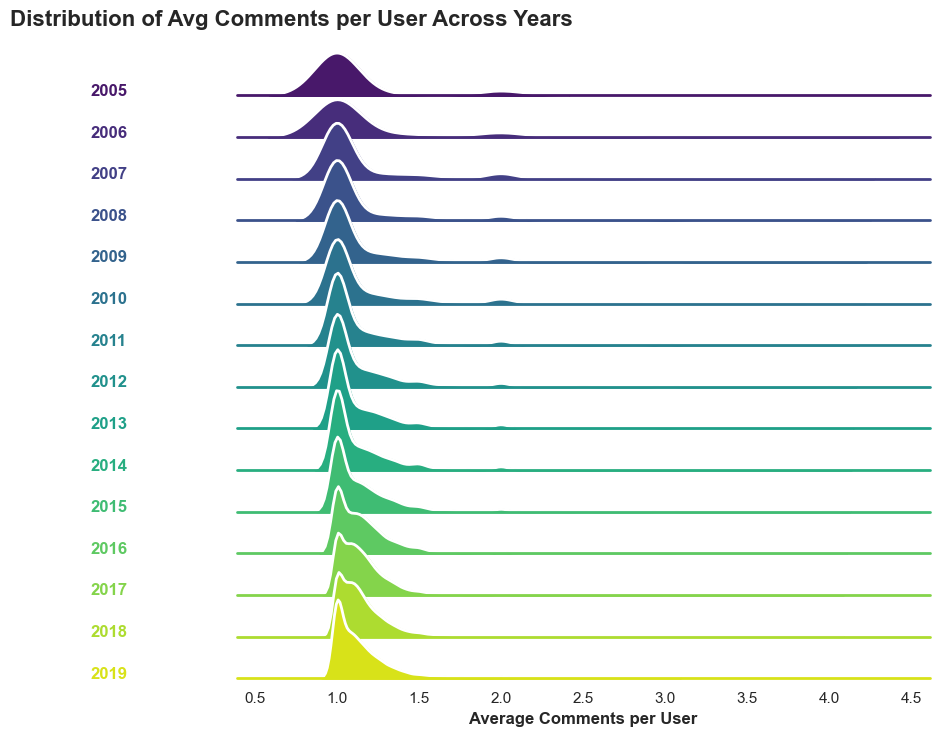

In [77]:
# Ridge Line Plot For Average Comments per User (Normal Users)

# year column is integer for proper sorting
subsampled_df['year'] = subsampled_df['year'].astype(int)

# Sort the DataFrame by year
subsampled_df = subsampled_df.sort_values(by='year', ascending=True)

# Reset the index after sorting (optional)
subsampled_df = subsampled_df.reset_index(drop=True)

# Seaborn clean theme
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Prepare data (already in `subsampled_df`)
subsampled_df['year'] = subsampled_df['year'].astype(int)  # Convert years to integers
subsampled_df['year'] = subsampled_df['year'].astype(str)  # Convert to string for categorical use

# Generate a color palete for years
pal = sns.color_palette(palette='viridis', n_colors=subsampled_df['year'].nunique())

# Create the FacetGrid for ridge line
g = sns.FacetGrid(
    subsampled_df,
    row='year',
    hue='year',
    aspect=15,  # Stretch plots horizontally
    height=0.5,  # Adjust height of each row
    palette=pal,
)

# Add density plots (kde)
g.map(
    sns.kdeplot,
    'avg_comments_per_user',
    bw_adjust=1,  # Bandwidth adjustment
    clip_on=False,
    fill=True,
    alpha=1,
    linewidth=1.5,
)

g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

# Add a white contour line around each density plot
g.map(
    sns.kdeplot,
    'avg_comments_per_user',
    bw_adjust=1,
    clip_on=False,  
    color="w",
    lw=2,
)

# Add a horizontal line at y=0 for each plot
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Add year labels to each plot
for i, ax in enumerate(g.axes.flat):
    ax.text(
        -0.5, 0.02,  # Adjust the position of the year label
        subsampled_df['year'].unique()[i],
        fontweight='bold',
        fontsize=12,
        color=ax.lines[-1].get_color(),
    )

# Adjust subplot overlap
g.fig.subplots_adjust(hspace=-0.5)

# Remove the density label from each y-axis
for ax in g.axes.flat:
    ax.set_ylabel("")  # Remove the y-axis labels for density

# Remove unnecessary axes details
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

# Set x-axis label
plt.xlabel("Average Comments per User", fontweight='bold', fontsize=12)
g.fig.suptitle('Distribution of Avg Comments per User Across Years',
               ha='right', fontsize=16, fontweight='bold')

# Show the plot
plt.show()

g.savefig("./image_aurel/ridge_line_normal.svg")


C:\Users\Laissy Aurélien\AppData\Roaming\Python\Python311\site-packages\seaborn\axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.



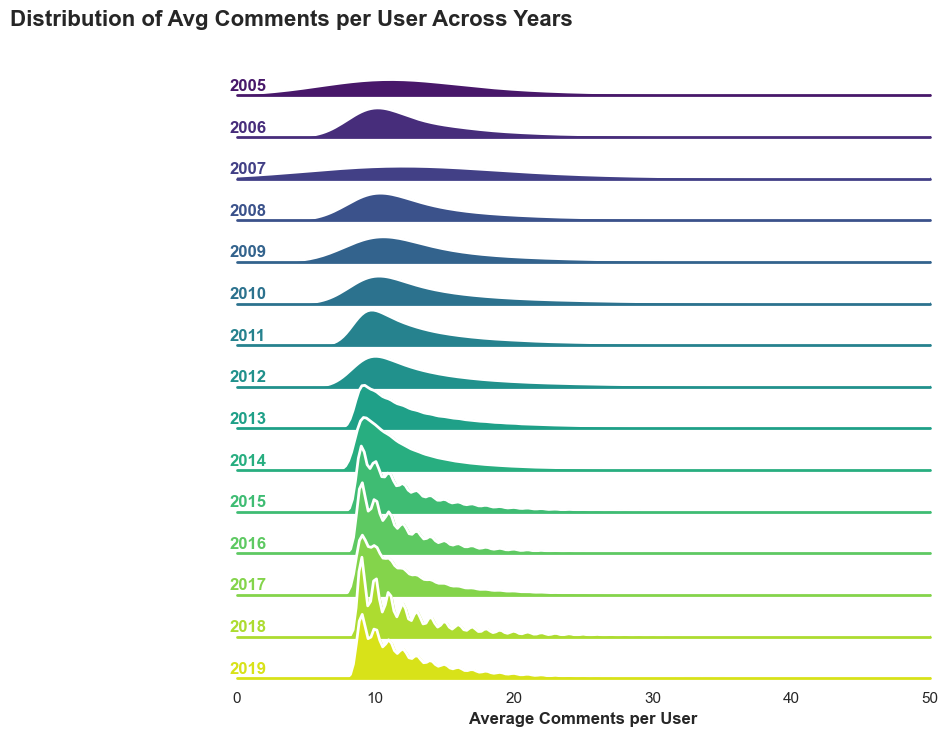

ValueError: Format 'html' is not supported (supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff, webp)

In [78]:
# Ridge Line Plot For Average Comments per User (Suspicious Users)

# year column is integer for proper sorting FOR SUSPICIOUS USERS
subsampled_df_sus['year'] = subsampled_df_sus['year'].astype(int)

# Sort the DataFrame by year
subsampled_df_sus = subsampled_df_sus.sort_values(by='year', ascending=True)
subsampled_df_sus = subsampled_df_sus.reset_index(drop=True)

# Seaborn clean theme
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# 'year' is treated as categorical for the plot
subsampled_df_sus['year'] = subsampled_df_sus['year'].astype(int)  # Convert years to integers
subsampled_df_sus['year'] = subsampled_df_sus['year'].astype(str)  # Convert to string for categorical use

# Generate a color palette for years
pal = sns.color_palette(palette='viridis', n_colors=subsampled_df_sus['year'].nunique())

# Create the FacetGrid for ridgeline
g = sns.FacetGrid(
    subsampled_df_sus,
    row='year',
    hue='year',
    aspect=15,  # Stretch plots horizontally
    height=0.5,  # Adjust height of each row
    palette=pal,
)

# Add density plots (kde)
g.map(
    sns.kdeplot,
    'avg_comments_per_user',
    bw_adjust=0.2,
    clip=(0, 50),  # Clip x-axis range to 0-5
    #clip_on=False,
    fill=True,
    alpha=1,
    linewidth=1.5,
)

g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

# Add a white contour line around each density plot
g.map(
    sns.kdeplot,
    'avg_comments_per_user',
    bw_adjust=0.2,
    clip=(0, 50),  # Clip x-axis range to 0-5
    #clip_on=False,  
    color="w",
    lw=2,
)

# Add a horizontal line at y=0 for each plot
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Add year labels to each plot
for i, ax in enumerate(g.axes.flat):
    ax.text(
        -0.5, 0.02, 
        subsampled_df_sus['year'].unique()[i],
        fontweight='bold',
        fontsize=12,
        color=ax.lines[-1].get_color(),
    )

# Adjust subplot overlap
g.fig.subplots_adjust(hspace=-0.5)

# Remove the density label from each y-axis
for ax in g.axes.flat:
    ax.set_ylabel("")  
    ax.set_xlim(0, 50) 

g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.xlabel("Average Comments per User", fontweight='bold', fontsize=12)
g.fig.suptitle('Distribution of Avg Comments per User Across Years',
               ha='right', fontsize=16, fontweight='bold')

# Show the plot
plt.show()

g.savefig("./image_aurel/ridge_line_sus.svg")
g.savefig("./image_aurel/ridge_line_sus.html")

<div class="alert alert-block alert-success">

#### <p style="text-align: center; margin-top: 0.5cm"> <span style="text-decoration: underline"> **Temporal Analysis** </span> </p>

</div>

#### *1st Definition of Lifetime*

In [29]:
# Computing the lifetime for each accounts
lifetime_df = df_sus.group_by("author").agg([
                pl.col("upload_date").min().alias("min"),
                pl.col("upload_date").max().alias("max")])

# Compute the difference
date_diff = (lifetime_df['max'] - lifetime_df['min']).alias("date_diff")

# Create the constant of one day to add
one_day = pl.duration(days=1).alias("one_day")

lifetime_df = lifetime_df.with_columns([
    (date_diff + one_day).alias("lifetime")
])

longuest_survival_type1=lifetime_df["lifetime"].max()
print(longuest_survival_type1)

longest_survival_row_type1 = lifetime_df.filter(pl.col("lifetime") == pl.col("lifetime").max())
print(longest_survival_row_type1)


#### *2nd Definition of Lifetime*

In [32]:
#Load normal users
df_sus_type_2=pl.read_parquet('data/data_type2/combi_suspicious_dataset2.parquet')
lifetime_df_type2 = df_sus_type_2.group_by("author").agg([
                pl.col("upload_date").filter(pl.col('videos_commented')>=10).min().alias("min"),
                pl.col("upload_date").max().alias("max")])

In [34]:
#Computing the lifetime for each accounts
date_diff_type2 = (lifetime_df_type2['max'] - lifetime_df_type2['min']).alias("date_diff")

# Create the constant of one day to add
one_day = pl.duration(days=1).alias("one_day")

lifetime_df_type2 = lifetime_df_type2.with_columns([
    (date_diff_type2 + one_day).alias("lifetime")
])

# lifetime_df.write_parquet('./data/data_type2/lifetime_sus.parquet')
longuest_survival_type2=lifetime_df_type2["lifetime"].max()
longest_survival_row_type2 = lifetime_df_type2.filter(pl.col("lifetime") == pl.col("lifetime").max())

For type 1 from df_sus:

In [ ]:
# Total comments for each unique author across every day
total_comments_df = df_sus.group_by("author").agg([
    pl.col("comments").sum().alias("total_comments"),
])

# Max number of comments done in a day for each author
max_daily_comments_df = df_sus.group_by("author").agg([
    pl.col("comments").max().alias("max_daily_comments"),
])

# Combine the two metrics into a single DataFrame
author_metrics_df = total_comments_df.join(max_daily_comments_df, on="author")

# Extract the row with the maximum total comments
row_with_max_total_comments = author_metrics_df.filter(pl.col("total_comments") == pl.col("total_comments").max())

# Extract the row with the maximum daily comments
row_with_max_daily_comments = df_sus.filter(pl.col("comments") == pl.col("comments").max())

# Print results
print("\nRow with Max Total Comments:")
print(row_with_max_total_comments)

print("\nRow with Max Daily Comments:")
print(row_with_max_daily_comments)

For the number of different videos commented: 

In [ ]:
# 1. Max number of different videos commented by an author in a day
max_videos_per_day = (
    df_sus.group_by(["author", "upload_date"])
    .agg([
        pl.col("video_id").n_unique().alias("unique_videos_commented")
    ])
    .group_by("author")
    .agg([
        pl.col("unique_videos_commented").max().alias("max_videos_in_a_day")
    ])
)

# 2. Max number of different videos commented across the entire dataset for each author
max_videos_overall = (
    df_sus.group_by("author")
    .agg([
        pl.col("video_id").n_unique().alias("max_videos_overall")
    ])
)

# Retrieve the row with the max number of different videos commented in a day
row_with_max_videos_in_a_day = max_videos_per_day.filter(
    pl.col("max_videos_in_a_day") == pl.col("max_videos_in_a_day").max()
)

# Retrieve the row with the max number of different videos commented across the entire dataset
row_with_max_videos_overall = max_videos_overall.filter(
    pl.col("max_videos_overall") == pl.col("max_videos_overall").max()
)
 
# Print the results
print("Row with Max Videos in a Day:")
print(row_with_max_videos_in_a_day)

print("\nRow with Max Videos Overall:")
print(row_with_max_videos_overall)

Max number of suspicious days according to the filter 1 and filter 2 

In [ ]:
# Filter 1: Count days with more than 10 comments per day
filter_1_days = (
    df_sus.filter(pl.col("comments") > 10)
    .group_by("author")
    .agg(pl.col("upload_date").n_unique().alias("suspicious_days_filter_1"))
)

# Filter 2: Count days with more than 10 unique videos commented
filter_2_days = (
    df_sus.group_by(["author", "upload_date"])
    .agg(pl.col("video_id").n_unique().alias("unique_videos_commented"))
    .filter(pl.col("unique_videos_commented") > 10)
    .group_by("author")
    .agg(pl.col("upload_date").n_unique().alias("suspicious_days_filter_2"))
)

# Extract rows with maximum suspicious days for each filter
max_suspicious_days_filter_1 = filter_1_days.filter(
    pl.col("suspicious_days_filter_1") == pl.col("suspicious_days_filter_1").max()
)
max_suspicious_days_filter_2 = filter_2_days.filter(
    pl.col("suspicious_days_filter_2") == pl.col("suspicious_days_filter_2").max()
)

print("\nRow with Max Suspicious Days (Filter 1):")
print(max_suspicious_days_filter_1)

print("\nRow with Max Suspicious Days (Filter 2):")
print(max_suspicious_days_filter_2)

Now for type_2 number of suspicious  days for each filters 

First we need to extract some data from the type 1 dataset to join on every author which is present in both datasets to get values for the numbers of comments

In [ ]:
inter_1_2=pl.read_parquet('data/suspicious_users_1_2.parquet')
recup_type_2= inter_1_2.join(df_sus, on="author", how="inner")

# Filter 1: Count days with more than 10 comments per day
max_suspicious_days_filter_1_type2 = (
    recup_type_2.filter(pl.col("comments") > 10)
    .group_by("author")
    .agg(pl.col("upload_date").n_unique().alias("suspicious_days_filter_1"))
    .filter(pl.col("suspicious_days_filter_1") == pl.col("suspicious_days_filter_1").max())
)

# Print the results
print("\nRow with Max Suspicious Days (Filter 1):")
print(max_suspicious_days_filter_1_type2)


In [49]:
# helper
filter_type2_on_type2=recup_type_2.filter(pl.col("comments") > 10).group_by("author").agg(pl.col("upload_date").n_unique().alias("suspicious_days_filter_1"))

In [ ]:
# To read partial Parquet files & create a single df
dataset = 'suspicious'
print(f"reading partial files '{dataset}_i.parquet'...")
parquet_files_type_2 = glob.glob(f'./data/data_type2/{dataset}_*.parquet')

In [ ]:
numb_app_df = pl.concat([pl.scan_parquet(dataset).filter(pl.col('videos_commented') >=10).group_by('author').count().collect(streaming=True)  
    for dataset in tqdm(parquet_files_type_2, desc='Processing df')
    ]).group_by('author').agg(pl.col("count").sum())

In [ ]:
# Find the row(s) with the maximum "count" meaning number of suspicious days in the type2 dataset
max_count_value = numb_app_df["count"].max()

# Retrieve the row(s) with the maximum count
rows_with_max_count = numb_app_df.filter(pl.col("count") == max_count_value)

# Print results
print(f"Maximum count value: {max_count_value}")
print("\nRow(s) with the maximum count:")
print(rows_with_max_count)

NOw number of max comment in a day and in whole lifetime ! 

In [ ]:
# Total comments for each unique author across every day
total_comments_df_type_2 = recup_type_2.group_by("author").agg([
    pl.col("comments").sum().alias("total_comments"),
])

# Max number of comments done in a day for each author
max_daily_comments_df_type2 = recup_type_2.group_by("author").agg([
    pl.col("comments").max().alias("max_daily_comments"),
])

# Combine the two metrics into a single DataFrame
author_metrics_df_type_2 = total_comments_df_type_2.join(max_daily_comments_df_type2, on="author")

# Extract the row with the maximum total comments
row_with_max_total_comments_type_2 = author_metrics_df_type_2.filter(pl.col("total_comments") == pl.col("total_comments").max())

# Extract the row with the maximum daily comments
row_with_max_daily_comments_type_2 = recup_type_2.filter(pl.col("comments") == pl.col("comments").max())

# Print results
print("\nRow with Max Total Comments:")
print(row_with_max_total_comments_type_2)

print("\nRow with Max Daily Comments:")
print(row_with_max_daily_comments_type_2)

Number of different videos commented in a day and in lifetime:
for type 2 so in : df_sus_type_2

In [ ]:

# 2. Max number of different videos commented across the entire dataset for each author
max_videos_overall_type_2 = df_sus_type_2.group_by("author").agg(pl.col("videos_commented").sum().alias("max_videos_overall"))

# Retrieve the row with the max number of different videos commented in a day
row_with_max_videos_in_a_day_type_2 = df_sus_type_2["videos_commented"].max()

# Retrieve the row with the max number of different videos commented across the entire dataset
row_with_max_videos_overall = max_videos_overall_type_2["max_videos_overall"].max()

In [ ]:
# 2. Retrieve the row with the max number of videos commented in a day
row_with_max_videos_in_a_day_type_2 = df_sus_type_2.filter(
    pl.col("videos_commented") == pl.col("videos_commented").max()
)

# 3. Retrieve the row with the max number of videos commented across the entire dataset
row_with_max_videos_overall = max_videos_overall_type_2.filter(
    pl.col("max_videos_overall") == pl.col("max_videos_overall").max()
)

# Print the results
print("Row with Max Videos in a Day:")
print(row_with_max_videos_in_a_day_type_2)

print("\nRow with Max Videos Overall:")
print(row_with_max_videos_overall)

***Now we have the max for all metrics so we need to retrieve the data for all metrics for all the best bots in their categories**

1) For lifetime it is a bot from type 2 dataset: 551221769 with 5245 days active !
2) For max number of comments in a day it is 260739815 (in type 1 and type 2) with 30990 comments.
3) For total number of comments during lifetime it is 157898414 with 351 984 comments !
4) For max number of different videos commented in a day it is 260739815 (in Type 1 &2) with 30990 comments. 
5) For the max number of different videos commented it is 157898414 with 352020 !
6) For the max number of suspicious days according to filter 1 (ie : # com >10 in a day) we have 303364156 with 2699 days!
7) For the max number of suspicious days according to filter 2 we have 3033641156 with 2907 days

We can see that we have 4 bots winning the 7 categories! Let's visualize our superbots!

In [ ]:
#Retrieving all the 7 metrics for each top value ! 
            #champ1     #champ2     #champ3  #champ4
champions= [551221769, 260739815, 157898414, 303364156]

#Retrieve the lifetime: 
champ1_lifetime= lifetime_df.filter(pl.col("author") == 551221769)
print(champ1_lifetime)

champ1_lifetime_t2= lifetime_df_type2.filter(pl.col("author") == 551221769)
print(champ1_lifetime_t2)
#retrieve max comm in a day: 
row_with_max_daily_comments_champ1 = df_sus.filter(pl.col("author") == 551221769).filter(pl.col("comments") == pl.col("comments").max())
print(row_with_max_daily_comments_champ1)

#retrieve total number of comm: 
total_com_champ1=total_comments_df.filter(pl.col("author") == 551221769)
print(total_com_champ1)

#retrieve max # of different videos in a day
max_videos_per_day_champ1=max_videos_per_day.filter(pl.col("author") == 551221769).filter(pl.col("max_videos_in_a_day")== pl.col("max_videos_in_a_day").max())
print(max_videos_per_day_champ1)

#retrieve max # of diff videos in total
max_videos_overall_champ1=max_videos_overall.filter(pl.col("author") == 551221769)
print(max_videos_overall_champ1)

#retrieve number of suspicious day type 1
suspicious_daysf1_champ1=filter_1_days.filter(pl.col("author") == 551221769)
print(suspicious_daysf1_champ1)

    #If in type2: 
suspicious_daysf1_t2_champ1=filter_type2_on_type2.filter(pl.col("author") == 551221769)
print(suspicious_daysf1_t2_champ1)

#retrieve number of suspicious day type 2 
suspicious_daysf2_champ1=filter_2_days.filter(pl.col("author") == 551221769)
print(suspicious_daysf2_champ1)
    #If in type2:
suspicious_daysf2_t2_champ1=numb_app_df.filter(pl.col("author") == 551221769)
print(suspicious_daysf2_t2_champ1)


In [ ]:
# Champions list
champions = [551221769, 260739815, 157898414, 303364156]

# Loop through each champion
for champ in champions:
    print(f"\n=== Retrieving metrics for Champion: {champ} ===")
    
    # Retrieve lifetime
    champ_lifetime = lifetime_df.filter(pl.col("author") == champ)
    print("Lifetime (Overall):")
    print(champ_lifetime)
    
    champ_lifetime_t2 = lifetime_df_type2.filter(pl.col("author") == champ)
    print("Lifetime (Type 2):")
    print(champ_lifetime_t2)
    
    # Retrieve max comments in a day
    row_with_max_daily_comments = df_sus.filter(pl.col("author") == champ).filter(
        pl.col("comments") == pl.col("comments").max()
    )
    print("Max Comments in a Day:")
    print(row_with_max_daily_comments)
    
    # Retrieve total number of comments
    total_com = total_comments_df.filter(pl.col("author") == champ)
    print("Total Comments:")
    print(total_com)
    
    # Retrieve max # of different videos in a day
    max_videos_per_day_champ = max_videos_per_day.filter(pl.col("author") == champ).filter(
        pl.col("max_videos_in_a_day") == pl.col("max_videos_in_a_day").max()
    )
    print("Max Different Videos in a Day:")
    print(max_videos_per_day_champ)
    
    # Retrieve max # of different videos overall
    max_videos_overall = max_videos_overall.filter(pl.col("author") == champ)
    print("Max Different Videos Overall:")
    print(max_videos_overall)
    
    # Retrieve max # of different videos overall in data from type 2
    max_videos_overall_type2=max_videos_overall_type_2.filter(pl.col("author") == champ)
    print("Max Different Videos Overall: (type2)")
    print(max_videos_overall_type2)

    # Retrieve number of suspicious days (Filter 1)
    suspicious_daysf1 = filter_1_days.filter(pl.col("author") == champ)
    print("Suspicious Days (Filter 1):")
    print(suspicious_daysf1)
    
    # Retrieve number of suspicious days (Filter 1, Type 2)
    suspicious_daysf1_t2 = filter_type2_on_type2.filter(pl.col("author") == champ)
    print("Suspicious Days (Filter 1, Type 2):")
    print(suspicious_daysf1_t2)
    
    # Retrieve number of suspicious days (Filter 2)
    suspicious_daysf2 = filter_2_days.filter(pl.col("author") == champ)
    print("Suspicious Days (Filter 2):")
    print(suspicious_daysf2)
    
    # Retrieve number of suspicious days (Filter 2, Type 2)
    suspicious_daysf2_t2 = numb_app_df.filter(pl.col("author") == champ)
    print("Suspicious Days (Filter 2, Type 2):")
    print(suspicious_daysf2_t2)

Now that we retrieved all the interesting values of our 4 champions bot, let's nroamlize by the highest value in each metrics and multiply by 99 to make FUT cards !

<div class="alert alert-block alert-success">

#### <p style="text-align: center; margin-top: 0.5cm"> <span style="text-decoration: underline"> **Radar plots to compare to bots** </span> </p>

</div>

In [138]:
# Define the data
champion_metrics = {
    "group": ['C-3PO', 'T-800', 'HAL 9000', 'AGENT SMITH'],
    "LIF": [5245, 4609, 1797, 3396],
    "MVD": [1, 1, 3, 4],
    "MDC": [42, 30990, 6365, 1387],
    "MVT": [4, 31186, 352020, 164069],
    "TLC": [81, 31009, 351984, 154765],
    "NSD_1": [3, 1, 666, 2699],
    "NSD_2": [5, 2, 667, 2907],
}

# Create the Polars DataFrame
champion_metrics_df = pl.DataFrame(champion_metrics)

# Add the "NSD" column as the maximum of "NSD_1" and "NSD_2", then drop the original columns
champion_metrics_df = champion_metrics_df.with_columns(
    pl.max_horizontal(["NSD_1", "NSD_2"]).alias("NSD")  # Compute max horizontally
).drop(["NSD_1", "NSD_2"])  # Drop the original columns

# Convert Polars DataFrame to Pandas DataFrame
champion_metrics_df = champion_metrics_df.to_pandas()

# Normalize only numeric columns and keep the 'group' column intact
champion_metrics_df = champion_metrics_df.set_index("group")  # Set 'group' as the index
champion_metrics_df = champion_metrics_df / champion_metrics_df.max() * 99  # Normalize and scale
champion_metrics_df = champion_metrics_df.round(0)  # Round values
champion_metrics_df = champion_metrics_df.reset_index()  # Restore 'group' as a column

# Display the result
print(champion_metrics_df)


         group   LIF   MVD   MDC   MVT   TLC   NSD
0        C-3PO  99.0  25.0   0.0   0.0   0.0   0.0
1        T-800  87.0  25.0  99.0   9.0   9.0   0.0
2     HAL 9000  34.0  74.0  20.0  99.0  99.0  23.0
3  AGENT SMITH  64.0  99.0   4.0  46.0  44.0  99.0


C:\Users\Laissy Aurélien\AppData\Local\Temp\ipykernel_6044\2895612206.py:49: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



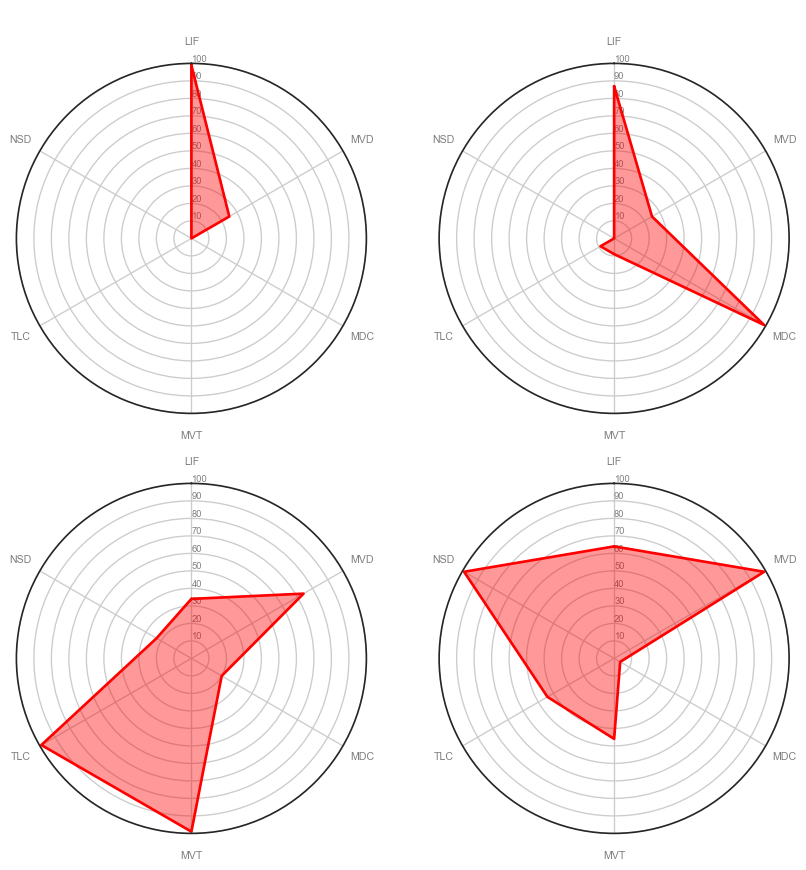

In [151]:
# PART 1: Define a function that do a plot for one line of the dataset!
def make_spider( row, title, color):

    # number of variable
    categories=list(champion_metrics_df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(2,2,row+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([10,20,30,40,50,60,70,80,90,100], ["10","20","30","40","50","60","70","80","90","100"], color="grey", size=7)
    plt.ylim(0,100)

    # Ind1
    values=champion_metrics_df.loc[row].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=11, color=color, y=1.1)

# PART 2: Apply the function to all individuals
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df.index))
 
# Loop to plot
for row in range(0, len(champion_metrics_df.index)):
    make_spider( row=row, title=" ", color='red')
plt.savefig('./image_aurel/radar_plts_champions.svg')

In [133]:
# PART 1: Define a function that creates a radar plot
def make_spider(row, title, color, output_path):
    # Number of variables
    categories = list(champion_metrics_df.columns[1:])  # Exclude 'group'
    N = len(categories)

    # Angles for the radar plot
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # Close the loop

    # Initialize the radar plot
    fig, ax = plt.subplots(figsize=(5, 5), dpi=96, subplot_kw={"polar": True})

    # Adjust axis directions
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Add labels for axes
    plt.xticks(angles[:-1], categories, color="grey", size=8)

    # Add y-labels
    ax.set_rlabel_position(0)
    plt.yticks(
        [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        ["10", "20", "30", "40", "50", "60", "70", "80", "90", "100"],
        color="grey",
        size=7,
    )
    plt.ylim(0, 100)

    # Data values
    values = champion_metrics_df.iloc[row, 1:].values.flatten().tolist()
    values += values[:1]  # Close the loop

    # Plot data
    ax.plot(angles, values, color=color, linewidth=2, linestyle="solid")
    ax.fill(angles, values, color=color, alpha=0.4)

    # Save radar plot
    plt.title(title, size=11, color=color, y=1.1)
    plt.savefig(output_path, bbox_inches="tight")
    plt.close()

# PART 2: Combine radar plot with PNG image
def combine_images(radar_path, png_path, output_path):
    # Open both images
    radar_img = Image.open(radar_path)
    png_img = Image.open(png_path)

    # Resize images to have the same height
    png_img = png_img.resize((int(radar_img.width * 0.8), radar_img.height))

    # Create a blank image for the composite
    combined_width = radar_img.width + png_img.width
    combined_img = Image.new("RGB", (combined_width, radar_img.height))

    # Paste the radar and PNG images side by side
    combined_img.paste(png_img, (0, 0))  # Left side: PNG
    combined_img.paste(radar_img, (png_img.width, 0))  # Right side: Radar plot

    # Save the combined image
    combined_img.save(output_path)

# PART 3: Main Loop
image_folder = "./fut"  # Folder containing PNG images

# Get a list of all PNG images in the folder
png_files = sorted(
    [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith(".png")]
)

champion_metrics_df = pd.DataFrame(champion_metrics)

# Create plots and combine images
output_folder = "./output"
os.makedirs(output_folder, exist_ok=True)

for row, png_path in zip(range(len(champion_metrics_df)), png_files):
    radar_path = os.path.join(output_folder, f"radar_{row + 1}.png")
    output_path = os.path.join(output_folder, f"composite_{row + 1}.png")

    # Create radar plot
    make_spider(row=row, title=f"Group {champion_metrics_df['group'][row]}", color="red", output_path=radar_path)

    # Combine radar plot with the corresponding PNG image
    combine_images(radar_path, png_path, output_path)

    print(f"Created: {output_path}")


Created: ./output\composite_1.png
Created: ./output\composite_2.png
Created: ./output\composite_3.png
Created: ./output\composite_4.png


## Violin plot of the normal and sus accounts

In [12]:
# List first two df
parquet_normal_type_2 = glob.glob(f'./data/data_type2/normal_*.parquet')[0]
parquet_sus_type_2 = glob.glob(f'./data/data_type2/suspicious_*.parquet')[0]

# No interest to load more than 1 df for the plot
df_norm = pd.read_parquet(parquet_normal_type_2)
df_sus =  pd.read_parquet(parquet_sus_type_2)
df_sus = df_sus[df_sus["videos_commented"] >= 10]

# Adding a column to discriminate between the 2 df
df_norm["category"]='normal'
df_sus["category"]='suspicious'

# Concatenating for the plot
df = pd.concat([df_norm[::5],df_sus[df_sus["videos_commented"] < 30]])

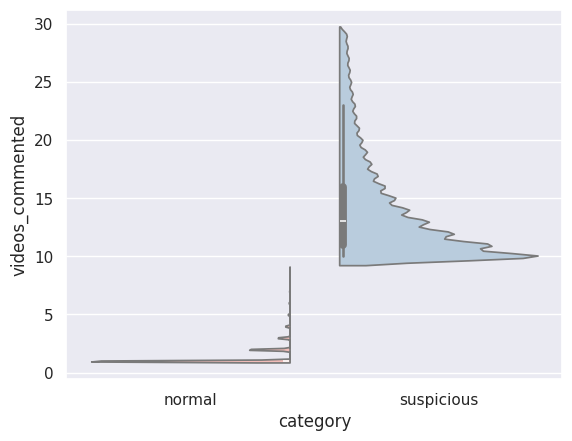

In [4]:
# Grouped violinplot
sns.set_theme(style="darkgrid")
sns.violinplot(x="category", y="videos_commented", hue="category", data=df, palette="Pastel1", split=True)
plt.show()

In [13]:
fig = go.Figure()

for category in ['normal', 'suspicious']:
    fig.add_trace(go.Violin(x=df['category'][df['category'] == category],
                            y=df['videos_commented'][df['category'] == category],
                            name=category,
                            box_visible=True,
                            meanline_visible=True))

fig.update_traces(meanline_visible=True)
fig.update_layout(violingap=0, violinmode='overlay', yaxis=dict(
        title=dict(
            text="Number of videos commented"
        )
    ),)
fig.write_html("images/dist_num_comments_norm_sus.html")

## How many videos do bots comment across time ?

In [20]:
dataset = 'suspicious'
print(f"reading partial files '{dataset}_i.parquet'...")
parquet_files_type_2 = glob.glob(f'./data/data_type2/{dataset}_*.parquet')

reading partial files 'suspicious_i.parquet'...


In [21]:
tot_numb_lines = 0

for dataset in tqdm(parquet_files_type_2, desc='Processing df'):
    tot_numb_lines += pl.scan_parquet(dataset).select('author').collect().shape[0]

print(f"There are {tot_numb_lines} in the suspicious type 2 dataset")

Processing df: 100%|██████████| 87/87 [00:07<00:00, 11.23it/s]

There are 1128015256 in the suspicious type 2 dataset


There are 3 845 594 unique authors in the type 2 dataset. We'll take a subset of it. We are going to only take a 100th of the authors to plot their evolutions.

In [20]:
unique_authors = pl.concat([pl.scan_parquet(file).select('author')
                        .unique().collect() for file in tqdm(parquet_files_type_2, 
                                                             desc='Processing df')]).unique()

unique_authors.write_parquet('./data/data_type2/unique_authors_sus.parquet')

Processing df: 100%|██████████| 87/87 [00:42<00:00,  2.05it/s]


In [7]:
authors_to_track = unique_authors.sample(n=int(len(unique_authors)/10000), seed=42)
authors_to_track

shape: (384, 1)
┌───────────┐
│ author    │
│ ---       │
│ i64       │
╞═══════════╡
│ 425038715 │
│ 207983007 │
│ 359250261 │
│ 278112256 │
│ 516861939 │
│ …         │
│ 500787460 │
│ 196127146 │
│ 111843811 │
│ 340429705 │
│ 357150107 │
└───────────┘

In [8]:
authors_evol =[]

for dataset in tqdm(parquet_files_type_2, desc='Processing df'):
    df = pl.read_parquet(dataset) # Reading df
    # Filtering only on the authors of interest
    df = df.filter(df['author'].is_in(authors_to_track['author'])) 

    # Recasting the df for pivoting
    df = df.select(
    pl.col('upload_date'),
    pl.col('author').cast(pl.String),
    pl.col('videos_commented')
    )

    # Pivoting
    df_pivot = df.pivot(index = 'upload_date', on='author', values='videos_commented')

    # Converting to sparse pandas DF for ease of use an light use of memory
    authors_evol.append(df_pivot.to_pandas().set_index('upload_date').astype(pd.SparseDtype("float64", np.nan)))


Processing df: 100%|██████████| 87/87 [00:22<00:00,  3.86it/s]


In [15]:
authors_evol = pd.concat(authors_evol).sort_index()
authors_evol[len(authors_evol.index)//4:]

22493098  22452192  21950024  122240083  123937047  124343873  \
upload_date                                                                  
2015-02-12        NaN       NaN       NaN        NaN        NaN        NaN   
2015-02-12        NaN       NaN       NaN        NaN        NaN        NaN   
2015-02-12        NaN       NaN       NaN        NaN        NaN        NaN   
2015-02-12        NaN       NaN       NaN        NaN        NaN        NaN   
2015-02-12        NaN       NaN       NaN        NaN        NaN        NaN   
...               ...       ...       ...        ...        ...        ...   
2019-10-03        NaN       NaN       NaN        NaN        NaN        NaN   
2019-10-03        NaN       NaN       NaN        NaN        NaN        NaN   
2019-10-03        NaN       NaN       NaN        NaN        NaN        NaN   
2019-10-03        NaN       NaN       NaN        NaN        NaN        NaN   
2019-10-03        NaN       NaN       NaN        NaN        NaN        NaN   

             122754481  120684503  122402592  5784802  ...  105249593  \
upload_date                                            ...              
2015-02-12         NaN        NaN        NaN      NaN  ...        NaN   
2015-02-12         NaN        NaN        NaN      NaN  ...        NaN   
2015-02-12         NaN        NaN        NaN      NaN  ...        NaN   
2015-02-12         NaN        NaN        NaN      NaN  ...        NaN   
2015-02-12         NaN        NaN        NaN      NaN  ...        NaN   
...                ...        ...        ...      ...  ...        ...   
2019-10-03         NaN        NaN        NaN      NaN  ...        NaN   
2019-10-03         NaN        NaN        NaN      NaN  ...        NaN   
2019-10-03         NaN        NaN        NaN      NaN  ...        NaN   
2019-10-03         NaN        NaN        NaN      NaN  ...        NaN   
2019-10-03         NaN        NaN        NaN      NaN  ...        NaN   

             105687674  515737209  509550730  514464195  187803435  192598860  \
upload_date                                                                     
2015-02-12         NaN        NaN        NaN        NaN        NaN        NaN   
2015-02-12         NaN        NaN        NaN        NaN        NaN        NaN   
2015-02-12         NaN        NaN        NaN        NaN        NaN        NaN   
2015-02-12         NaN        NaN        NaN        NaN        NaN        NaN   
2015-02-12         NaN        NaN        NaN        NaN        NaN        NaN   
...                ...        ...        ...        ...        ...        ...   
2019-10-03         NaN        NaN        NaN        NaN        NaN        NaN   
2019-10-03         NaN        NaN        NaN        NaN        NaN        NaN   
2019-10-03         NaN        NaN        NaN        NaN        NaN        NaN   
2019-10-03         NaN        NaN        NaN        NaN        NaN        NaN   
2019-10-03         NaN        NaN        NaN        NaN        NaN        NaN   

             192519526  189862071  188893395  
upload_date                                   
2015-02-12         NaN        NaN        NaN  
2015-02-12         NaN        NaN        NaN  
2015-02-12         NaN        NaN        NaN  
2015-02-12         NaN        NaN        NaN  
2015-02-12         NaN        NaN        NaN  
...                ...        ...        ...  
2019-10-03         NaN        NaN        NaN  
2019-10-03         NaN        NaN        NaN  
2019-10-03         NaN        NaN        NaN  
2019-10-03         NaN        NaN        NaN  
2019-10-03         NaN        NaN        NaN  

[67704 rows x 384 columns]

## Time evolution of different quantities

In [3]:
dataset = 'suspicious'
print(f"reading partial files '{dataset}_i.parquet'...")
parquet_files_type_2 = glob.glob(f'./data/data_type2/{dataset}_*.parquet')

reading partial files 'suspicious_i.parquet'...


In [ ]:
result = pl.concat([pl.scan_parquet(dataset).group_by('upload_date').agg([
                    pl.col("videos_commented").sum(),
                    pl.col("author").unique().count()]).collect(streaming=True)
                    for dataset in tqdm(parquet_files_type_2, desc='Processing chunks')
                    ]).group_by('upload_date').agg([pl.col("videos_commented").sum(),
                    pl.col("author").unique().count()]).rename({'author' : 'distinct_bots'})

result = result.with_columns(comments_per_bot = result['videos_commented'] / result['distinct_bots'])
result.write_parquet('./data/data_type2/time_series_type_2.parquet')

Processing chunks: 100%|██████████| 87/87 [02:46<00:00,  1.91s/it]


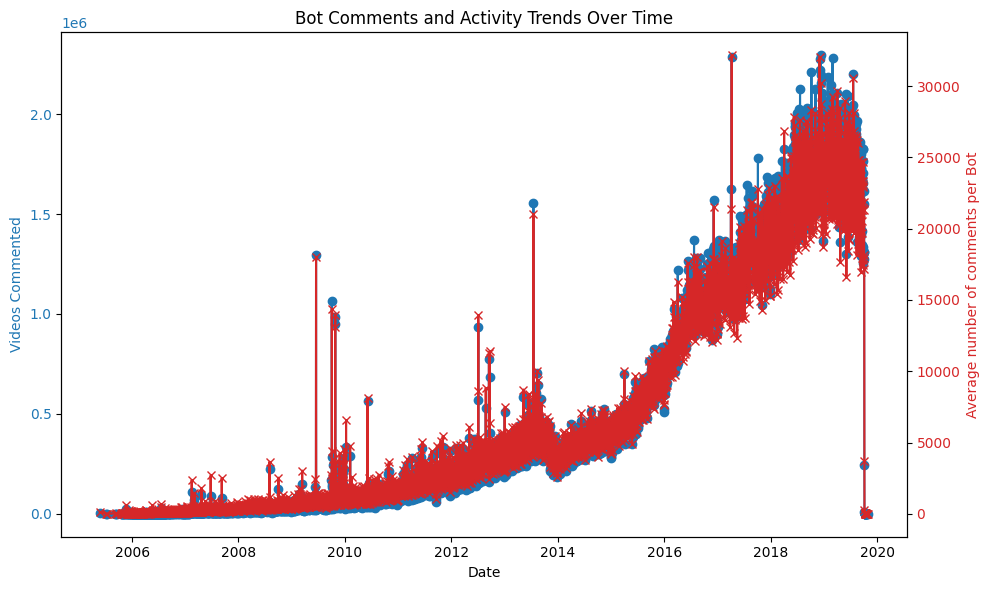

In [34]:
result = pl.read_parquet('./data/data_type2/time_series_type_2.parquet')
result = result.sort('upload_date')

# Plot the data
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot videos commented
ax1.plot(result['upload_date'], result['videos_commented'], color='tab:blue', label='Videos Commented', marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Videos Commented', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create second y-axis to plot comments per bot
ax2 = ax1.twinx()
ax2.plot(result['upload_date'], result['comments_per_bot'], color='tab:red', label='Comments per Bot', marker='x')
ax2.set_ylabel('Average number of comments per Bot', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and layout adjustments
plt.title('Bot Comments and Activity Trends Over Time')
fig.tight_layout()  # Adjust layout to fit everything
plt.xticks(rotation=45)

# Show the plot
plt.show()


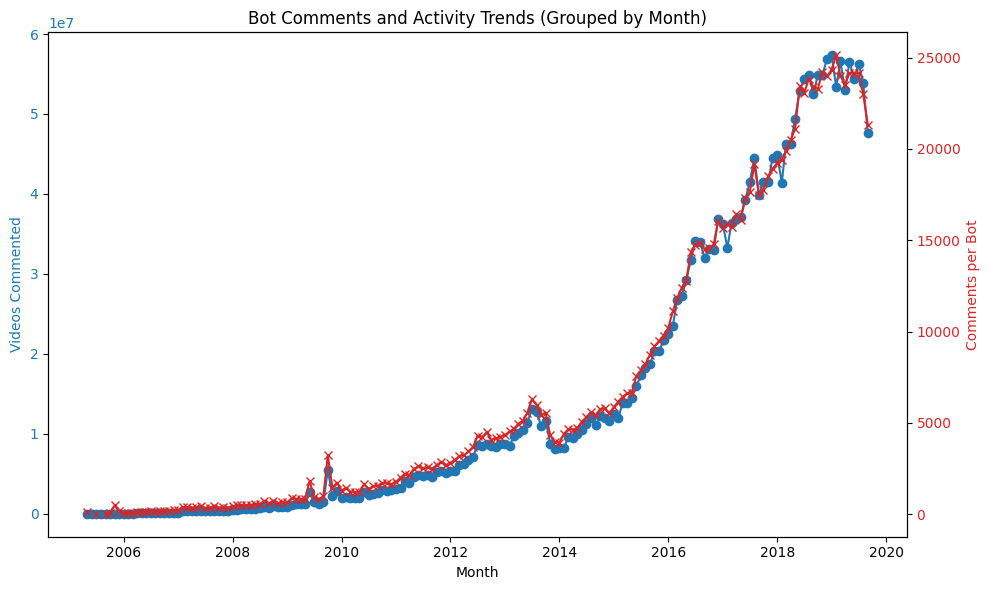

In [ ]:
# Group by month
result_monthly = result.to_pandas().groupby(pd.Grouper(key='upload_date', freq='MS')).agg(
    videos_commented=('videos_commented', 'sum'),
    distinct_bots=('distinct_bots', 'sum')  # Use sum for distinct_bots
).reset_index()[:-1] #Getting rid of the last month as it is in complete

# Calculate comments per bot per month
result_monthly['comments_per_bot'] = result_monthly['videos_commented'] / result_monthly['distinct_bots']

# Plot the monthly data
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot videos commented per month
ax1.plot(result_monthly['upload_date'], result_monthly['videos_commented'], color='tab:blue', label='Videos Commented (Monthly)', marker='o')
ax1.set_xlabel('Month')
ax1.set_ylabel('Videos Commented', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create second y-axis to plot comments per bot per month
ax2 = ax1.twinx()
ax2.plot(result_monthly['upload_date'], result_monthly['comments_per_bot'], color='tab:red', label='Comments per Bot (Monthly)', marker='x')
ax2.set_ylabel('Comments per Bot', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and layout adjustments
plt.title('Bot Comments and Activity Trends (Grouped by Month)')
fig.tight_layout()  # Adjust layout to fit everything
plt.xticks(rotation=45)

# Show the plot
plt.show()

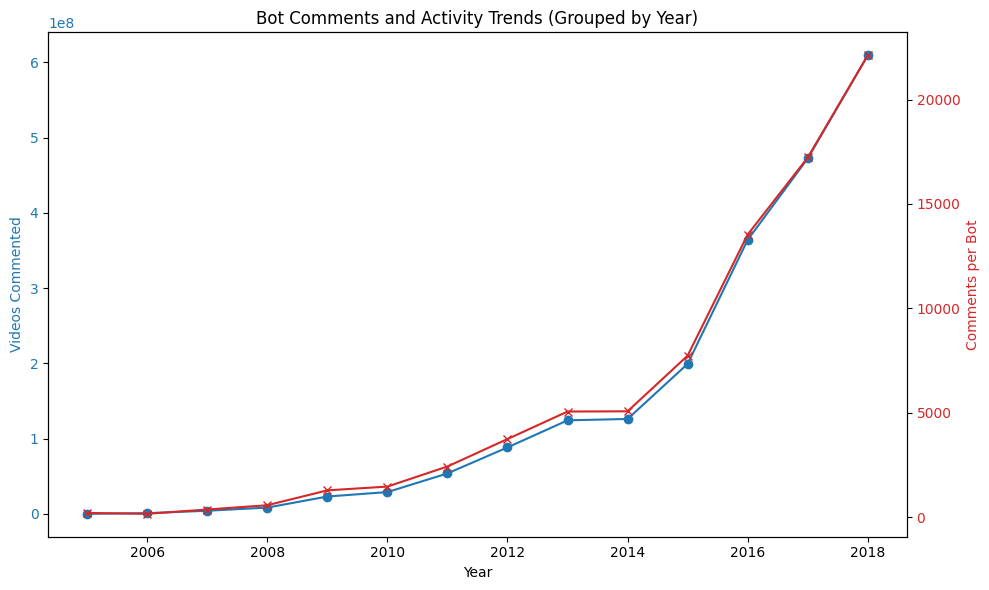

In [51]:
# Group by month
result_yearly = result.to_pandas().groupby(pd.Grouper(key='upload_date', freq='YS')).agg(
    videos_commented=('videos_commented', 'sum'),
    distinct_bots=('distinct_bots', 'sum')  # Use sum for distinct_bots
).reset_index()[:-1] #Getting rid of the last year as it is in complete

# Calculate comments per bot per month
result_yearly['comments_per_bot'] = result_yearly['videos_commented'] / result_yearly['distinct_bots']

# Plot the yearly data
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot videos commented per month
ax1.plot(result_yearly['upload_date'], result_yearly['videos_commented'], color='tab:blue', label='Videos Commented (yearly)', marker='o')
ax1.set_xlabel('Year')
ax1.set_ylabel('Videos Commented', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create second y-axis to plot comments per bot per month
ax2 = ax1.twinx()
ax2.plot(result_yearly['upload_date'], result_yearly['comments_per_bot'], color='tab:red', label='Comments per Bot (yearly)', marker='x')
ax2.set_ylabel('Comments per Bot', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and layout adjustments
plt.title('Bot Comments and Activity Trends (Grouped by Year)')
fig.tight_layout()  # Adjust layout to fit everything
plt.xticks(rotation=45)

# Show the plot
plt.show()

## Lifetime

### Bots' lifetime

In [ ]:
lifetime_df = pl.concat([pl.scan_parquet(dataset).group_by("author").agg([
        pl.col("upload_date").min().alias("min"),
        pl.col("upload_date").max().alias("max")
        ]).collect(streaming=True)  
    for dataset in tqdm(parquet_files_type_2, desc='Processing df')])

Processing df: 100%|██████████| 87/87 [02:09<00:00,  1.49s/it]


In [49]:
# To make sure that we have the min and max of all users
lifetime_df = lifetime_df.group_by("author").agg([
                            pl.col("min").min().alias("min"),
                            pl.col("max").max().alias("max")
                            ])

# Computing the lifetime for each accounts
date_diff = (lifetime_df['max'] - lifetime_df['min']).alias("date_diff")

# Create the constant of one day to add
one_day = pl.duration(days=1).alias("one_day")

lifetime_df = lifetime_df.with_columns([
    (date_diff + one_day).alias("lifetime")
])

lifetime_df.write_parquet('./data/data_type2/lifetime_sus.parquet')

shape: (8, 2)
┌────────────┬────────────────────────────┐
│ statistic  ┆ value                      │
│ ---        ┆ ---                        │
│ str        ┆ str                        │
╞════════════╪════════════════════════════╡
│ count      ┆ 3845585                    │
│ null_count ┆ 0                          │
│ mean       ┆ 3129 days, 13:04:10.550000 │
│ min        ┆ 1 day, 0:00:00             │
│ 25%        ┆ 2347 days, 0:00:00         │
│ 50%        ┆ 3315 days, 0:00:00         │
│ 75%        ┆ 3988 days, 0:00:00         │
│ max        ┆ 5247 days, 0:00:00         │
└────────────┴────────────────────────────┘


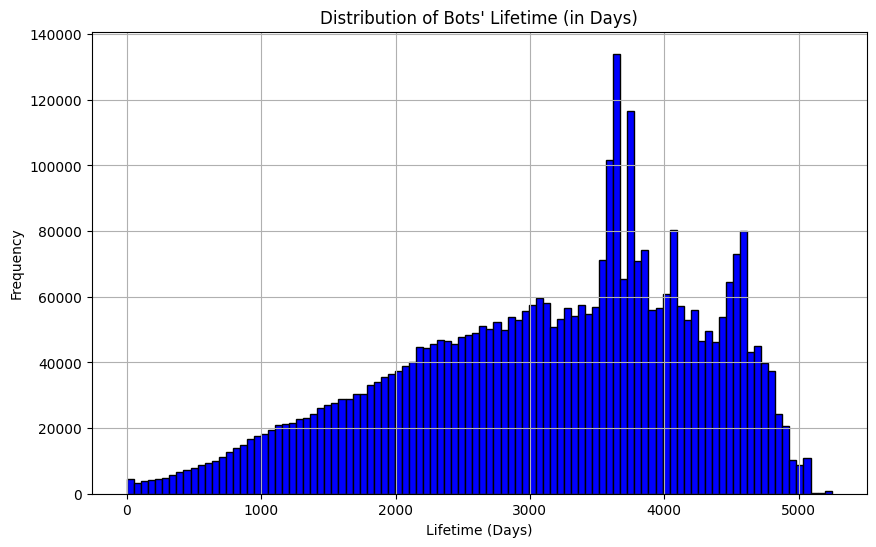

In [3]:
lifetime_df = pl.read_parquet('./data/data_type2/lifetime_sus.parquet')

# Extracting the lifetime and converting it to float64 for plotting
lifetime = lifetime_df.select(
    total_days = pl.col.lifetime.dt.total_days(),
)

#Plot the distribution of bot lifetimes
plt.figure(figsize=(10, 6))
plt.hist(lifetime, bins=100, color='blue', edgecolor='black')
plt.title("Distribution of Bots' Lifetime (in Days)")
plt.xlabel('Lifetime (Days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Bots' suspicious lifetime

In [ ]:
lifetime_sus_df = pl.concat([pl.scan_parquet(dataset).filter(pl.col('videos_commented')>=10).group_by("author")
        .agg([
        pl.col("upload_date").min().alias("min"),
        pl.col("upload_date").max().alias("max")
        ]).collect(streaming=True)  
    for dataset in tqdm(parquet_files_type_2, desc='Processing df')])

Processing df: 100%|██████████| 87/87 [00:57<00:00,  1.50it/s]


In [43]:
# To make sure that we have the min and max of all users
lifetime_sus_df = lifetime_sus_df.group_by("author").agg([
                            pl.col("min").min().alias("min"),
                            pl.col("max").max().alias("max")
                            ])

# Computing the lifetime for each accounts
date_diff = (lifetime_sus_df['max'] - lifetime_sus_df['min']).alias("date_diff")

# Create the constant of one day to add
one_day = pl.duration(days=1).alias("one_day")

lifetime_sus_df = lifetime_sus_df.with_columns([
    (date_diff + one_day).alias("lifetime")
])

lifetime_sus_df.write_parquet('./data/data_type2/lifetime_sus_sus_days.parquet')

shape: (8, 2)
┌────────────┬──────────────────────────┐
│ statistic  ┆ value                    │
│ ---        ┆ ---                      │
│ str        ┆ str                      │
╞════════════╪══════════════════════════╡
│ count      ┆ 3845585                  │
│ null_count ┆ 0                        │
│ mean       ┆ 332 days, 3:44:21.835000 │
│ min        ┆ 1 day, 0:00:00           │
│ 25%        ┆ 1 day, 0:00:00           │
│ 50%        ┆ 7 days, 0:00:00          │
│ 75%        ┆ 354 days, 0:00:00        │
│ max        ┆ 5148 days, 0:00:00       │
└────────────┴──────────────────────────┘


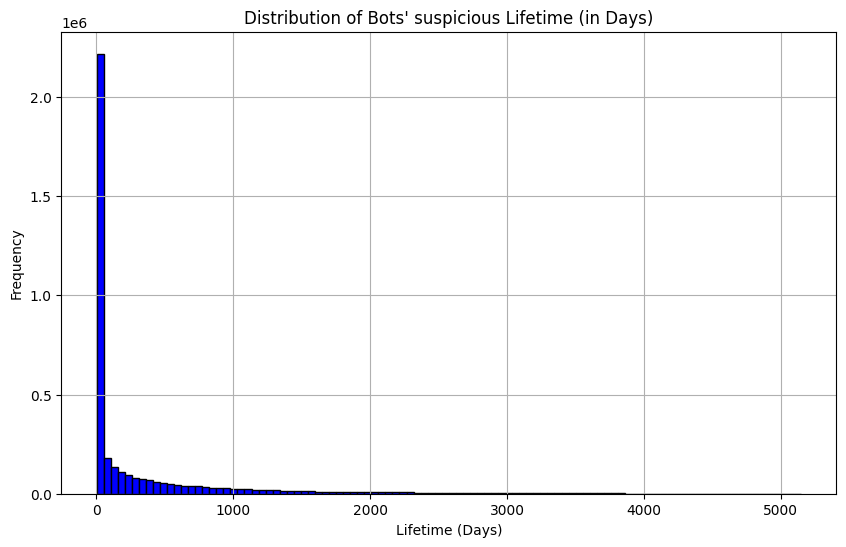

In [4]:
lifetime_sus_df = pl.read_parquet('./data/data_type2/lifetime_sus_sus_days.parquet')
# Display the lifetime distribution
print(lifetime_sus_df['lifetime'].describe())

# Extracting the lifetime and converting it to float64 for plotting
lifetime = lifetime_sus_df.select(
    total_days = pl.col.lifetime.dt.total_days(),
)

#Plot the distribution of bot lifetimes
plt.figure(figsize=(10, 6))
plt.hist(lifetime, bins=100, color='blue', edgecolor='black')
plt.title("Distribution of Bots' suspicious Lifetime (in Days)")
plt.xlabel('Lifetime (Days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Bot's Lifetime Definition 3

First suspicious day and last day of appearance

In [27]:
lifetime_sus_2_df = lifetime_sus_df.clone()

lifetime_sus_2_df = lifetime_sus_2_df.sort("author").with_columns(
    max = lifetime_df.sort("author")["max"])

In [30]:
# Computing the lifetime for each accounts
date_diff = (lifetime_sus_2_df['max'] - lifetime_sus_2_df['min']).alias("date_diff")

# Create the constant of one day to add
one_day = pl.duration(days=1).alias("one_day")

lifetime_sus_2_df = lifetime_sus_2_df.with_columns([
    (date_diff + one_day).alias("lifetime")
])

lifetime_sus_2_df.write_parquet('./data/data_type2/lifetime_sus_sus_2_days.parquet')

shape: (8, 2)
┌────────────┬────────────────────────────┐
│ statistic  ┆ value                      │
│ ---        ┆ ---                        │
│ str        ┆ str                        │
╞════════════╪════════════════════════════╡
│ count      ┆ 3845585                    │
│ null_count ┆ 0                          │
│ mean       ┆ 1002 days, 13:01:12.789000 │
│ min        ┆ 1 day, 0:00:00             │
│ 25%        ┆ 313 days, 0:00:00          │
│ 50%        ┆ 722 days, 0:00:00          │
│ 75%        ┆ 1382 days, 0:00:00         │
│ max        ┆ 5245 days, 0:00:00         │
└────────────┴────────────────────────────┘


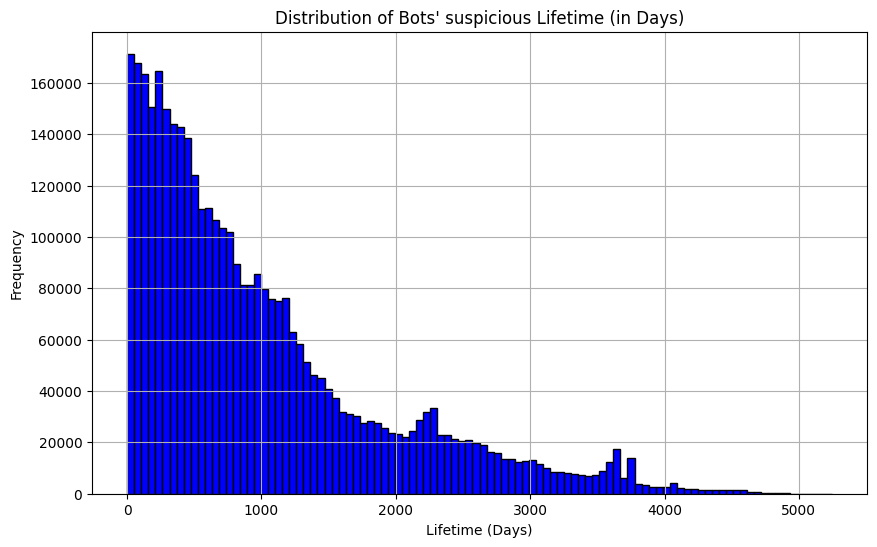

In [5]:
lifetime_sus_2_df = pl.read_parquet('./data/data_type2/lifetime_sus_sus_2_days.parquet')
# Display the lifetime distribution
print(lifetime_sus_2_df['lifetime'].describe())

# Extracting the lifetime and converting it to float64 for plotting
lifetime = lifetime_sus_2_df.select(
    total_days = pl.col.lifetime.dt.total_days(),
)

#Plot the distribution of bot lifetimes
plt.figure(figsize=(10, 6))
plt.hist(lifetime, bins=100, color='blue', edgecolor='black')
plt.title("Distribution of Bots' suspicious Lifetime (in Days)")
plt.xlabel('Lifetime (Days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Normal Users' lifetime

In [46]:
# To read partial Parquet files & create a single df
dataset = 'normal'
print(f"reading partial files '{dataset}_i.parquet'...")
parquet_normal_type_2 = glob.glob(f'./data/data_type2/{dataset}_*.parquet')

reading partial files 'normal_i.parquet'...


In [50]:
lifetime_normal_df = pl.concat([pl.scan_parquet(dataset).group_by("author").agg([
        pl.col("upload_date").min().alias("min"),
        pl.col("upload_date").max().alias("max")
        ]).collect(streaming=True)  
    for dataset in tqdm(parquet_normal_type_2, desc='Processing df')])

Processing df: 100%|██████████| 87/87 [00:12<00:00,  7.19it/s]


shape: (8, 2)
┌────────────┬────────────────────────────┐
│ statistic  ┆ value                      │
│ ---        ┆ ---                        │
│ str        ┆ str                        │
╞════════════╪════════════════════════════╡
│ count      ┆ 1154048                    │
│ null_count ┆ 0                          │
│ mean       ┆ 2894 days, 12:17:32.703000 │
│ min        ┆ 34 days, 0:00:00           │
│ 25%        ┆ 2131 days, 0:00:00         │
│ 50%        ┆ 2941 days, 0:00:00         │
│ 75%        ┆ 3675 days, 0:00:00         │
│ max        ┆ 5247 days, 0:00:00         │
└────────────┴────────────────────────────┘


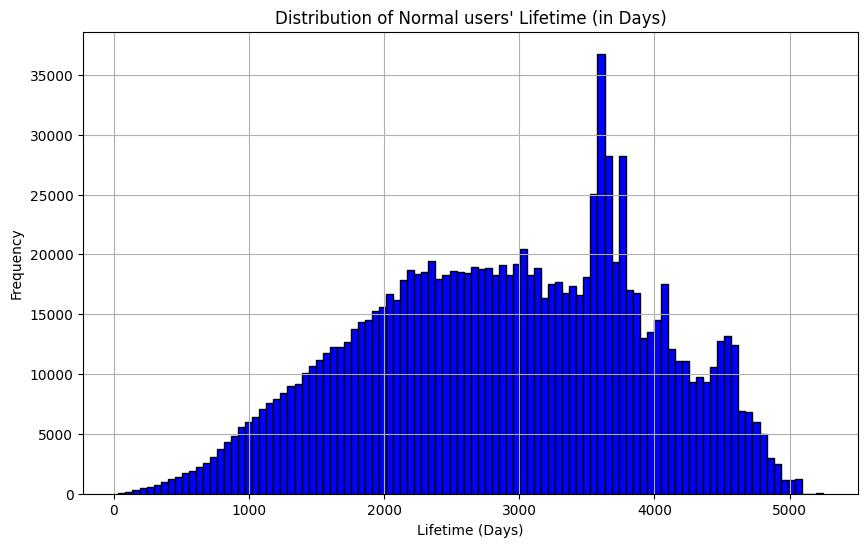

In [6]:
lifetime_normal_df = pl.read_parquet('./data/data_type2/lifetime_normal.parquet')
# Display the lifetime distribution
print(lifetime_normal_df['lifetime'].describe())

# Extracting the lifetime and converting it to float64 for plotting
lifetime = lifetime_normal_df.select(
    total_days = pl.col.lifetime.dt.total_days(),
)

#Plot the distribution of bot lifetimes
plt.figure(figsize=(10, 6))
plt.hist(lifetime, bins=100, color='blue', edgecolor='black')
plt.title("Distribution of Normal users' Lifetime (in Days)")
plt.xlabel('Lifetime (Days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### Comparing Normal users and Bots

In [58]:
# Adding a column to discriminate between the 2 df
lifetime_df = lifetime_df.with_columns(pl.lit('suspicious').alias("category"))
lifetime_normal_df = lifetime_normal_df.with_columns(pl.lit('normal').alias("category"))

# Concatenating for the plot
df = pl.concat([lifetime_normal_df,lifetime_df]).to_pandas()

# Converting datetime to float
df["lifetime"] = df["lifetime"]/np.timedelta64(1,'D')

/tmp/ipykernel_8483/1781384631.py:8: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  sns.violinplot(x="category", y="lifetime", hue="category", data=df[::2],


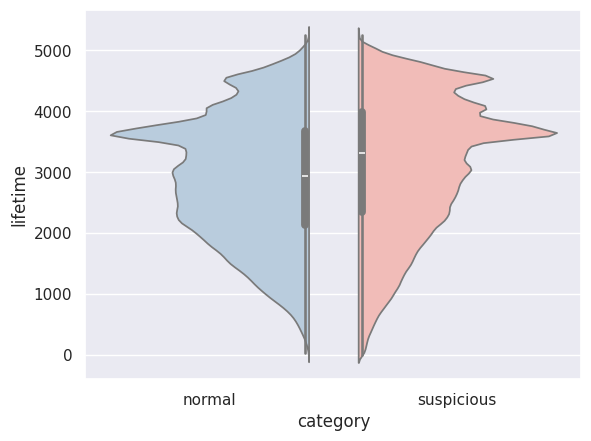

In [59]:
# Grouped violinplot
sns.set_theme(style="darkgrid")

# Changing the order of the first two parts of the palette so normal is blue and sus is red
modified_palette = sns.color_palette("Pastel1")
modified_palette[0], modified_palette[1] = modified_palette[1], modified_palette[0]

sns.violinplot(x="category", y="lifetime", hue="category", data=df[::2], 
               palette=modified_palette, split=True)

plt.show()

In [60]:
# Adding a column to discriminate between the 2 df
lifetime_sus_df = lifetime_sus_df.with_columns(pl.lit('suspicious').alias("category"))

# Concatenating for the plot
df = pl.concat([lifetime_normal_df,lifetime_sus_df]).to_pandas()

# Converting datetime to float
df["lifetime"] = df["lifetime"]/np.timedelta64(1,'D')

/tmp/ipykernel_8483/2789910436.py:8: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  sns.violinplot(x="category", y="lifetime", hue="category", data=df[::2],


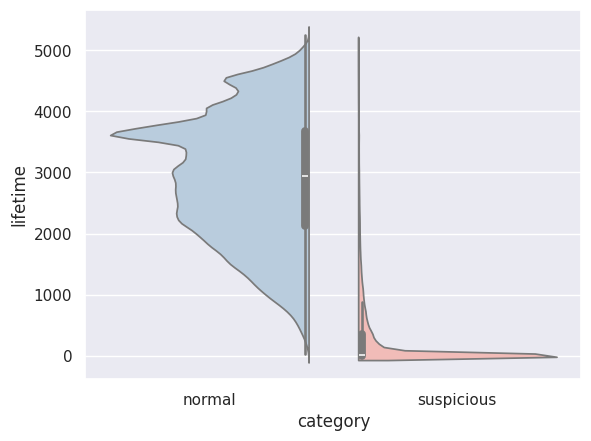

In [62]:
# Grouped violinplot
sns.set_theme(style="darkgrid")

# Changing the order of the first two parts of the palette so normal is blue and sus is red
modified_palette = sns.color_palette("Pastel1")
modified_palette[0], modified_palette[1] = modified_palette[1], modified_palette[0]

sns.violinplot(x="category", y="lifetime", hue="category", data=df[::2], 
               palette=modified_palette, split=True)
plt.show()

#### Lifetime Definition 3

In [49]:
# Adding a column to discriminate between the 2 df
lifetime_sus_2_df = lifetime_sus_2_df.with_columns(pl.lit('suspicious').alias("category"))

# Concatenating for the plot
df = pl.concat([lifetime_normal_df,lifetime_sus_2_df]).to_pandas()

# Converting datetime to float
df["lifetime"] = df["lifetime"]/np.timedelta64(1,'D')

/tmp/ipykernel_8483/2789910436.py:8: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  sns.violinplot(x="category", y="lifetime", hue="category", data=df[::2],


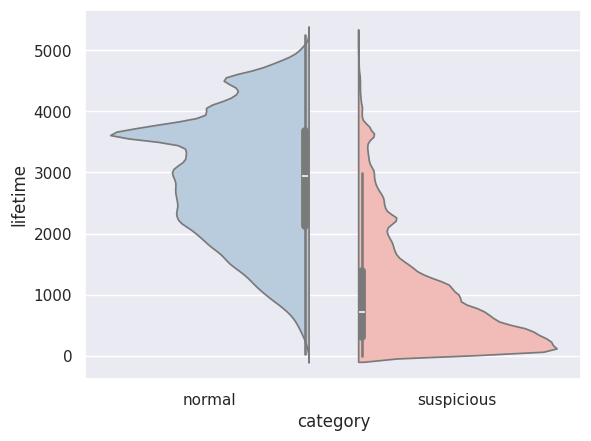

In [57]:
# Grouped violinplot
sns.set_theme(style="darkgrid")

# Changing the order of the first two parts of the palette so normal is blue and sus is red
modified_palette = sns.color_palette("Pastel1")
modified_palette[0], modified_palette[1] = modified_palette[1], modified_palette[0]

sns.violinplot(x="category", y="lifetime", hue="category", data=df[::2], 
               palette=modified_palette, split=True)
plt.show()

### Violin Plot with Plotly

In [3]:
lifetime_df = pl.read_parquet('./data/data_type2/lifetime_sus.parquet')
lifetime_normal_df = pl.read_parquet('./data/data_type2/lifetime_normal.parquet')
lifetime_sus_2_df = pl.read_parquet('./data/data_type2/lifetime_sus_sus_2_days.parquet')
lifetime_sus_df = pl.read_parquet('./data/data_type2/lifetime_sus_sus_days.parquet')

# Adding a column to discriminate between the df
lifetime_normal_df = lifetime_normal_df.with_columns(pl.lit('normal').alias("category"))
lifetime_df = lifetime_df.with_columns(pl.lit('suspicious1').alias("category"))
lifetime_sus_df = lifetime_sus_df.with_columns(pl.lit('suspicious2').alias("category"))
lifetime_sus_2_df = lifetime_sus_2_df.with_columns(pl.lit('suspicious3').alias("category"))

In [15]:
df = pl.concat([lifetime_df[["lifetime",'category']].with_columns(type_life = 1),
           lifetime_normal_df[["lifetime",'category'
                               ]].with_columns(
                                   type_life = 1).replace_column(
                                                             1,pl.Series("category",['normal1']*len(lifetime_normal_df))),
           lifetime_sus_df[["lifetime",'category']].with_columns(type_life = 2),
           lifetime_normal_df[["lifetime",'category'
                               ]].with_columns(
                                   type_life = 2).replace_column(
                                                             1,pl.Series("category",['normal2']*len(lifetime_normal_df))),
           lifetime_sus_2_df[["lifetime",'category']].with_columns(type_life = 3),
           lifetime_normal_df[["lifetime",'category'
                               ]].with_columns(
                                   type_life = 3).replace_column(
                                                             1,pl.Series("category",['normal3']*len(lifetime_normal_df))),
           ]).to_pandas()[::20]

df["lifetime"] = df["lifetime"]/np.timedelta64(1,'D')

In [34]:
# Create subplots
fig = make_subplots(rows=1, cols=3, shared_yaxes=True)

# Add traces to the first subplot
fig.add_trace(go.Violin(x=df['type_life'][df['category'] == 'normal1'],
                        y=df['lifetime'][df['category'] == 'normal1'],
                        legendgroup='Yes', scalegroup='normal1', name='Normal',
                        side='negative',
                        line_color='blue',
                        width=0.8),  # Increase width
              row=1, col=1)

fig.add_trace(go.Violin(x=df['type_life'][df['category'] == 'suspicious1'],
                        y=df['lifetime'][df['category'] == 'suspicious1'],
                        legendgroup='No', scalegroup='normal1', name='Suspicious',
                        side='positive',
                        line_color='orange',
                        width=0.8),  # Increase width
              row=1, col=1)

# Add traces to the second subplot
fig.add_trace(go.Violin(x=df['type_life'][df['category'] == 'normal2'],
                        y=df['lifetime'][df['category'] == 'normal2'],
                        legendgroup='Yes', scalegroup='normal2', name='Normal',
                        side='negative',
                        line_color='blue',
                        width=0.8,
                        showlegend=False),  # Increase width
              row=1, col=2)

fig.add_trace(go.Violin(x=df['type_life'][df['category'] == 'suspicious2'],
                        y=df['lifetime'][df['category'] == 'suspicious2'],
                        legendgroup='No', scalegroup='normal2', name='Suspicious',
                        side='positive',
                        line_color='orange',
                        width=0.8,
                        showlegend=False),  # Increase width
              row=1, col=2)

# Add traces to the third subplot
fig.add_trace(go.Violin(x=df['type_life'][df['category'] == 'normal3'],
                        y=df['lifetime'][df['category'] == 'normal3'],
                        legendgroup='Yes', scalegroup='normal3', name='Normal',
                        side='negative',
                        line_color='blue',
                        width=0.8,
                        showlegend=False),  # Increase width
              row=1, col=3)

fig.add_trace(go.Violin(x=df['type_life'][df['category'] == 'suspicious3'],
                        y=df['lifetime'][df['category'] == 'suspicious3'],
                        legendgroup='No', scalegroup='normal3', name='Suspicious',
                        side='positive',
                        line_color='orange',
                        width=0.8,
                        showlegend=False),  # Increase width
              row=1, col=3)

# Update traces and layout
fig.update_traces(meanline_visible=True)
fig.update_layout(
    violingap=0.1,  # Adjust the gap between violins if needed
    violinmode='overlay',
    yaxis_title="Lifetime"
)

# Center the x-axis title for each subplot
for i in range(1, 4):
    fig.update_xaxes(title_text="Type of Lifetime", title_standoff=20, row=1, col=i)

fig.write_html("./images/violin_plots_lifetime.html")


In [ ]:
# Adding a column to discriminate between the 2 df
lifetime_df = lifetime_df.with_columns(pl.lit('suspicious').alias("category"))
lifetime_normal_df = lifetime_normal_df.with_columns(pl.lit('normal').alias("category"))

# Concatenating for the plot
df = pl.concat([lifetime_normal_df,lifetime_df]).to_pandas()

# Converting datetime to float
df["lifetime"] = df["lifetime"]/np.timedelta64(1,'D')

In [ ]:

# Concatenating for the plot
df = pl.concat([lifetime_normal_df,lifetime_sus_df]).to_pandas()

# Converting datetime to float
df["lifetime"] = df["lifetime"]/np.timedelta64(1,'D')

In [ ]:

# Concatenating for the plot
df = pl.concat([lifetime_normal_df,lifetime_sus_2_df]).to_pandas()

# Converting datetime to float
df["lifetime"] = df["lifetime"]/np.timedelta64(1,'D')

## Counting the number of suspicious days

In [3]:
numb_app_df = pl.concat([pl.scan_parquet(dataset).filter(pl.col('videos_commented') >=10).group_by('author').count().collect(streaming=True)  
    for dataset in tqdm(parquet_files_type_2, desc='Processing df')
    ]).group_by('author').agg(pl.col("count").sum())

numb_app_df.write_parquet('./data/data_type2/numb_sus_days.parquet')

Processing df:   0%|          | 0/87 [00:00<?, ?it/s]

/tmp/ipykernel_75851/3938692391.py:1: DeprecationWarning: `LazyGroupBy.count` is deprecated. It has been renamed to `len`.
  numb_app_df = pl.concat([pl.scan_parquet(dataset).filter(pl.col('videos_commented') >=10).group_by('author').count().collect(streaming=True)
Processing df: 100%|██████████| 87/87 [00:56<00:00,  1.54it/s]


shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 3.845585e6 │
│ null_count ┆ 0.0        │
│ mean       ┆ 6.746844   │
│ std        ┆ 25.976464  │
│ min        ┆ 1.0        │
│ 25%        ┆ 1.0        │
│ 50%        ┆ 2.0        │
│ 75%        ┆ 4.0        │
│ max        ┆ 2907.0     │
└────────────┴────────────┘


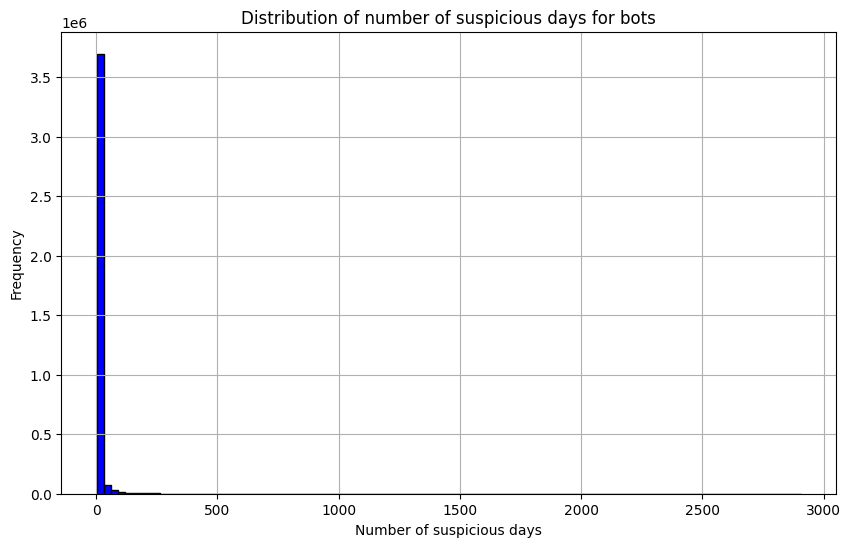

In [4]:
# Display the lifetime distribution

numb_app_df = pl.read_parquet('./data/data_type2/numb_sus_days.parquet')
print(numb_app_df['count'].describe())

#Plot the distribution of bot lifetimes
plt.figure(figsize=(10, 6))
plt.hist(numb_app_df['count'], bins=100, color='blue', edgecolor='black')
plt.title('Distribution of number of suspicious days for bots')
plt.xlabel('Number of suspicious days')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### <p style="text-align: center; margin-top: 0.5cm"> <span style="text-decoration: underline"> **How Does Commenting Frequency Affects Lifetime ?** </span> </p>

### Finding correlation between lifetime and number of active days

In [42]:
lifetime_df = pl.read_parquet('./data/data_type2/lifetime_sus.parquet')
lifetime_sus_df = pl.read_parquet('./data/data_type2/lifetime_sus_sus_days.parquet')
lifetime_sus_2_df = pl.read_parquet('./data/data_type2/lifetime_sus_sus_2_days.parquet')
numb_app_df = pl.read_parquet('./data/data_type2/numb_sus_days.parquet')

lifetime_sus_df = lifetime_sus_df.rename({'lifetime' : 'lifetime_sus'})
lifetime_sus_2_df = lifetime_sus_2_df.rename({'lifetime' : 'lifetime_sus_2'})

In [43]:
freq_effect_df = lifetime_df[['author','lifetime']].join(other = lifetime_sus_df[['author','lifetime_sus']],
                                                    on = 'author').join(
                                                        other=lifetime_sus_2_df[['author','lifetime_sus_2']],
                                                          on ='author'
                                                    ).join(other=numb_app_df, on ='author')

freq_effect_df = freq_effect_df.rename({'count' : 'numb_day_sus'})

In [44]:
# Converting the datetime index to float and filtering for the plot
lifetime = freq_effect_df.filter(freq_effect_df["numb_day_sus"] <=50).select(
    total_days = pl.col.lifetime.dt.total_days(),
)

lifetime_sus = freq_effect_df.filter(freq_effect_df["numb_day_sus"] <=50).select(
    total_days = pl.col.lifetime_sus.dt.total_days(),
)

lifetime_sus_2 = freq_effect_df.filter(freq_effect_df["numb_day_sus"] <=50).select(
    total_days = pl.col.lifetime_sus_2.dt.total_days(),
)

# Extracting the number of suspicious days
numb_day_sus = freq_effect_df.filter(freq_effect_df["numb_day_sus"] <=50)['numb_day_sus']

/home/matthieu/Documents/ADA/adavenv/lib/python3.8/site-packages/seaborn/axisgrid.py:1832: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=self.x, y=self.y, **kwargs)


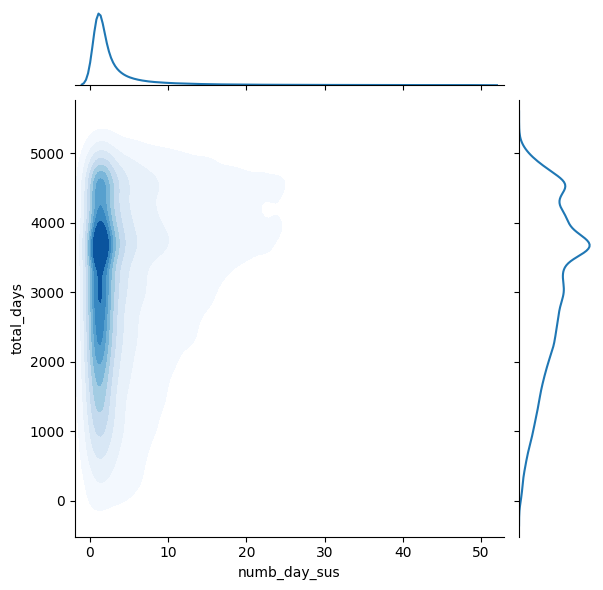

In [11]:
# 2D density + marginal distribution:
sns.jointplot(x=numb_day_sus[::50], 
              y=lifetime['total_days'][::50],
              cmap="Blues", shade=True, kind='kde')
plt.show()

In [8]:
P = freq_effect_df.select(pl.corr('lifetime','numb_day_sus', method='pearson')).item()
S = freq_effect_df.select(pl.corr('lifetime','numb_day_sus', method='spearman')).item()

print(f"Pearson's coeff : {P}")
print(f"Spearman's coeff : {S}")

Pearson's coeff : 0.0703894061755216
Spearman's coeff : 0.14220209342170084


/home/matthieu/Documents/ADA/adavenv/lib/python3.8/site-packages/seaborn/axisgrid.py:1832: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=self.x, y=self.y, **kwargs)


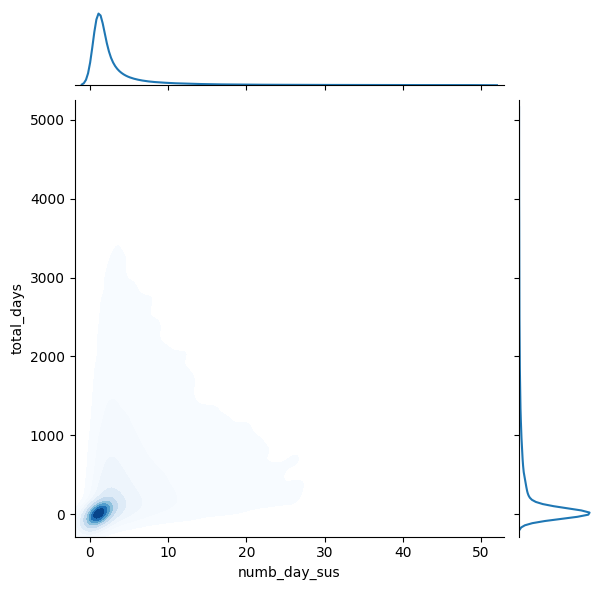

In [12]:
# 2D density + marginal distribution:
sns.jointplot(x=numb_day_sus[::50], 
              y=lifetime_sus['total_days'][::50],
              cmap="Blues", shade=True, kind='kde')
plt.show()

In [9]:
P = freq_effect_df.select(pl.corr('lifetime_sus','numb_day_sus', method='pearson')).item()
S = freq_effect_df.select(pl.corr('lifetime_sus','numb_day_sus', method='spearman')).item()

print(f"Pearson's coeff : {P}")
print(f"Spearman's coeff : {S}")

Pearson's coeff : 0.35471627229490776
Spearman's coeff : 0.9171492562122827


/home/matthieu/Documents/ADA/adavenv/lib/python3.8/site-packages/seaborn/axisgrid.py:1832: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=self.x, y=self.y, **kwargs)


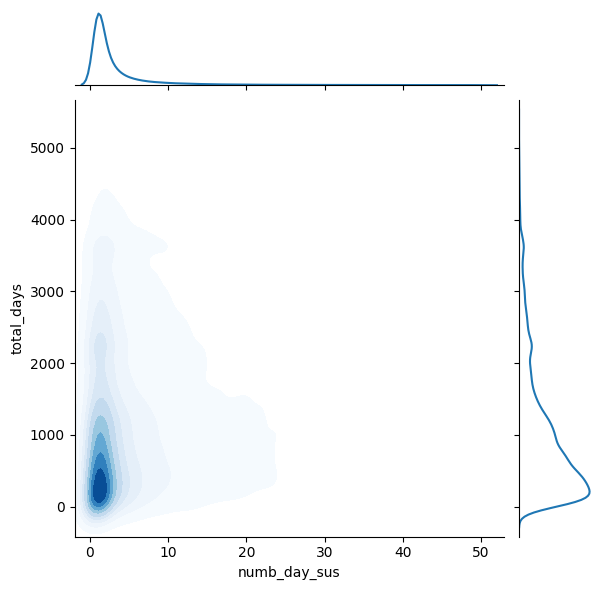

In [14]:
# 2D density + marginal distribution:
sns.jointplot(x=numb_day_sus[::50], 
              y=lifetime_sus_2['total_days'][::50],
              cmap="Blues", shade=True, kind='kde')
plt.show()

In [10]:
P = freq_effect_df.select(pl.corr('lifetime_sus_2','numb_day_sus', method='pearson')).item()
S = freq_effect_df.select(pl.corr('lifetime_sus_2','numb_day_sus', method='spearman')).item()

print(f"Pearson's coeff : {P}")
print(f"Spearman's coeff : {S}")

Pearson's coeff : 0.1475772223925091
Spearman's coeff : 0.21236229703353962


### Correlation between the number of posts made and the number of active days

In [28]:
df = pl.scan_parquet(parquet_files_type_2[0])
df.group_by("author").agg(pl.col('videos_commented').sum()).collect(streaming=True)

shape: (44_413, 2)
┌──────────┬──────────────────┐
│ author   ┆ videos_commented │
│ ---      ┆ ---              │
│ i64      ┆ u32              │
╞══════════╪══════════════════╡
│ 21818839 ┆ 1368             │
│ 26155526 ┆ 486              │
│ 26305904 ┆ 953              │
│ 24433447 ┆ 5207             │
│ 24523856 ┆ 866              │
│ …        ┆ …                │
│ 21472631 ┆ 255              │
│ 20715510 ┆ 1005             │
│ 23334407 ┆ 673              │
│ 24788539 ┆ 317              │
│ 26126849 ┆ 124              │
└──────────┴──────────────────┘

In [25]:
freq_effect_df = pl.concat([pl.scan_parquet(dataset).group_by("author").agg(
    pl.col('videos_commented').sum()).collect(streaming=True) 
    for dataset in tqdm(parquet_files_type_2, desc='Processing df')
    ]).group_by('author').agg(pl.col("videos_commented").sum())

Processing df: 100%|██████████| 87/87 [01:49<00:00,  1.26s/it]


In [27]:
freq_effect_df = freq_effect_df.join(other = numb_app_df, on ='author')
freq_effect_df = freq_effect_df.rename({'count' : 'numb_day_sus'})
freq_effect_df.write_parquet('./data/data_type2/numb_vid_comment_author_sus.parquet')

numb_videos_commented = freq_effect_df.filter(freq_effect_df["numb_day_sus"] <=40,
                      freq_effect_df["videos_commented"] <=2500)['videos_commented']

numb_day_sus = freq_effect_df.filter(freq_effect_df["numb_day_sus"] <=40,
                      freq_effect_df["videos_commented"] <=2500)['numb_day_sus']

/home/matthieu/Documents/ADA/adavenv/lib/python3.8/site-packages/seaborn/axisgrid.py:1832: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=self.x, y=self.y, **kwargs)


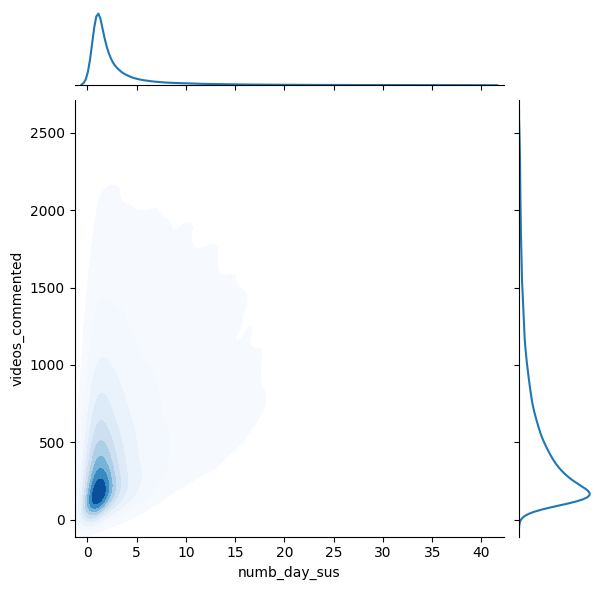

In [15]:
# 2D density + marginal distribution:
sns.jointplot(x=numb_day_sus[::50], 
              y=numb_videos_commented[::50],
              cmap="Blues", shade=True, kind='kde')
plt.show()

In [23]:
freq_effect_df.select(pl.corr('videos_commented','numb_day_sus'))

shape: (1, 1)
┌──────────────────┐
│ videos_commented │
│ ---              │
│ f64              │
╞══════════════════╡
│ 0.79839          │
└──────────────────┘

In [15]:
df= pd.DataFrame()
df["numb_day_sus"] = numb_day_sus[::50]
df['lifetime'] = lifetime['total_days'][::50]

fig = px.density_heatmap(df, x="numb_day_sus", y="lifetime", marginal_x="violin", marginal_y="violin")
fig.update_layout(width=500, 
                  height=500,
                  xaxis_title="Number of suspicious days",
                  yaxis_title="Lifetime def 1")
fig.write_html("./images/corr_LT1_sus_days.html")

In [18]:
df= pd.DataFrame()
df["numb_day_sus"] = numb_day_sus[::50]
df['lifetime'] = lifetime_sus['total_days'][::50]

fig = px.density_heatmap(df, x="numb_day_sus", y="lifetime", marginal_x="violin", marginal_y="violin")
fig.update_layout(width=500, 
                  height=500,
                  xaxis_title="Number of suspicious days",
                  yaxis_title="Lifetime def 2")
fig.write_html("./images/corr_LT2_sus_days.html")

In [47]:
df= pd.DataFrame()
df["numb_day_sus"] = numb_day_sus[::50]
df['lifetime'] = lifetime_sus_2['total_days'][::50]

fig = px.density_heatmap(df, x="numb_day_sus", y="lifetime", marginal_x="violin", marginal_y="violin")
fig.update_layout(width=500, 
                  height=500,
                  xaxis_title="Number of suspicious days",
                  yaxis_title="Lifetime def 3")
fig.write_html("./images/corr_LT3_sus_days.html")

In [38]:
df= pd.DataFrame()
df["numb_day_sus"] = numb_day_sus[::50]
df['videos_commented'] = numb_videos_commented[::50]

fig = px.density_heatmap(df, x="numb_day_sus", y="videos_commented", marginal_x="violin", marginal_y="violin")
fig.update_layout(width=500, 
                  height=500,
                  xaxis_title="Number of suspicious days",
                  yaxis_title="Number of videos commented")
fig.write_html("./images/corr_vid_com_sus_days.html")

**ChatGPT explanation :** <br> 
A Pearson's correlation coefficient (r) of 0.591166 indicates a moderate positive linear relationship between two variables. Here's a more detailed interpretation:

    Range of Pearson's r: The coefficient ranges from -1 to 1.
        1 indicates a perfect positive linear relationship.
        -1 indicates a perfect negative linear relationship.
        0 indicates no linear relationship.

    Magnitude of the coefficient:
        0 to ±0.1: No or negligible correlation
        ±0.1 to ±0.3: Weak correlation
        ±0.3 to ±0.5: Moderate correlation
        ±0.5 to ±0.7: Moderate to strong correlation
        ±0.7 to ±0.9: Strong correlation
        ±0.9 to ±1: Very strong correlation

Given your coefficient of 0.591166:

    It falls within the range of 0.5 to 0.7, indicating a moderate to strong positive linear relationship.
    This suggests that as one variable increases, the other variable tends to increase as well, and this relationship is reasonably consistent.

However, it's important to remember that correlation does not imply causation. While there is a linear relationship between the two variables, it does not mean that one variable is causing the changes in the other. Additionally, other factors such as outliers, the range of data, and the presence of non-linear relationships should also be considered when interpreting the correlation coefficient.

In [24]:
# Create and fit model
model = LinearRegression()
subsample=10
model.fit(np.array(numb_day_sus[::subsample]).reshape(-1, 1), 
          np.array(numb_videos_commented[::subsample]).reshape(-1, 1))

r2 = model.score(np.array(numb_day_sus[::subsample]).reshape(-1, 1), 
          np.array(numb_videos_commented[::subsample]).reshape(-1, 1))
coefficients = model.coef_
intercept = model.intercept_

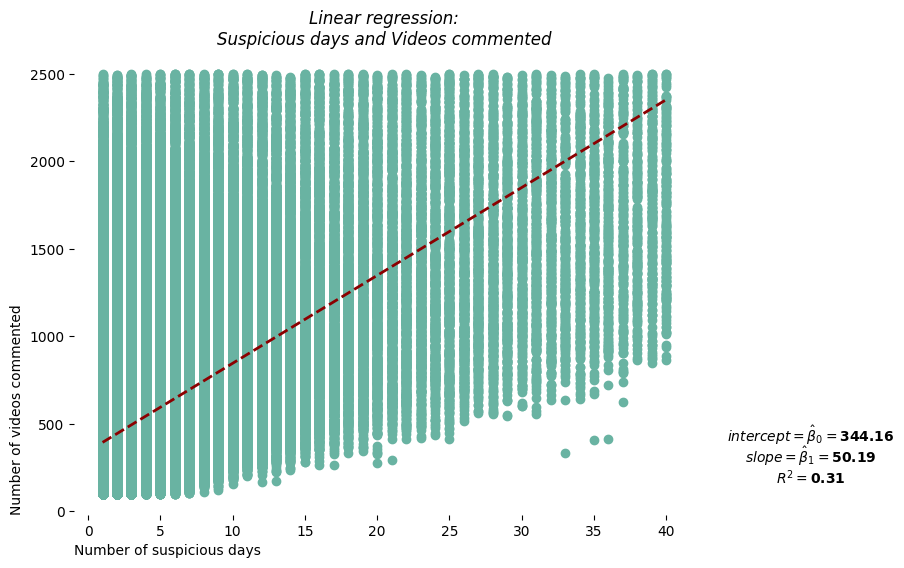

In [25]:
# Init plots
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(numb_day_sus[::subsample], numb_videos_commented[::subsample],
           color='#69b3a2', zorder=1)

# Define parameters of the regression line
num = len(numb_day_sus[::subsample])
start = numb_day_sus[::subsample].min()
end = numb_day_sus[::subsample].max()
xseq = np.linspace(start, end, num=num)

# Plot regressuion line
ax.plot(xseq, intercept+coefficients[0]*xseq,
        color="darkred", lw=2, zorder=2, linestyle="--")

# Add params
beta0 = r'$intercept = \hat\beta_0 =$' + str(round(intercept[0],2))
ax.text(50, 400, beta0, fontsize=10, weight='bold', horizontalalignment='center')

beta1 = r'$slope = \hat\beta_1 =$' + str(round(coefficients[0,0],2))
ax.text(50, 280, beta1, fontsize=10, weight='bold', horizontalalignment='center')

r_squared = r'$R^2 =$' + str(round(r2,2))
ax.text(50, 160, r_squared, fontsize=10, weight='bold', horizontalalignment='center')

# Removes spines
ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

# Add a title and axis label
ax.set_title('Linear regression:\nSuspicious days and Videos commented',
             style='italic')
ax.set_xlabel('Number of suspicious days', loc='left')
ax.set_ylabel('Number of videos commented', loc='bottom')

# Show the plot
plt.show()

# <p style="text-align: center; margin-top: 0.5cm"> <span style="text-decoration: underline"> **BOT RANKING** </span> </p>


### Most active 

In [2]:
dataset = 'suspicious'
print(f"reading partial files '{dataset}_i.parquet'...")
parquet_files_type_2 = glob.glob(f'./data/data_type2/{dataset}_*.parquet')

df = pl.concat([pl.scan_parquet(file).select(["author","videos_commented"]).filter(pl.col('videos_commented') >=10).sort("videos_commented", descending=True).slice(0,10).collect()
                            for file in tqdm(parquet_files_type_2, desc="Processing df")
                            ]).unique("author").sort("videos_commented", descending=True).slice(0,10).sort("videos_commented", descending=False) # To get the top 10

df = df.to_pandas()

reading partial files 'suspicious_i.parquet'...


Processing df: 100%|██████████| 87/87 [00:14<00:00,  6.16it/s]


In [3]:
# Replacing the author names by funny names
bot_names = [
    "T-800",       # Terminator
    "Agent Smith",   # The Matrix
    "HAL 9000",    # 2001: A Space Odyssey
    "Optimus Prime", # Transformers
    "Iron Giant",  # The Iron Giant
    "R2-D2",       # Star Wars
    "Bender",      # Futurama
    "C-3PO",       # Star Wars
    "BB-8",        # Star Wars
    "Wall-E"       # Wall-E
]

df["author"] = bot_names[::-1]

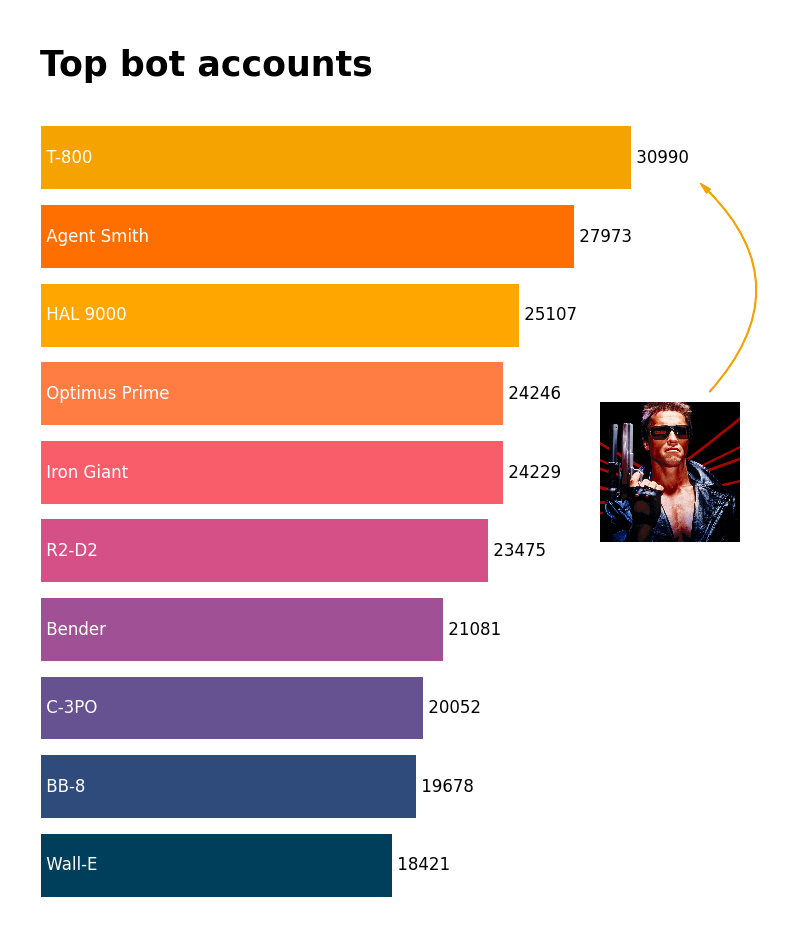

In [5]:
# initialize the figure
fig, ax = plt.subplots(figsize=(10, 11))

# define custom colors
custom_colors = [
    "#003f5c", "#2f4b7c", "#665191", "#a05195", "#d45087", 
    "#f95d6a", "#ff7c43", "#ffa600", "#ff6f00", "#f4a300"
]

colors={}

for i in range(10):
    colors[bot_names[i]] = custom_colors[9-i]

# remove axis
ax.axis('off')

# Setting the colors
c = [colors[name] for name in df['author']]
text_color = 'black'

# create the plot
ax.barh(df["author"], df['videos_commented'], color=c)
for i, (value, name) in enumerate(zip(df['videos_commented'],
                                      df['author'])):
    ax.text(x=10, y=i, s=f' {name}',
            ha='left', va='center', fontsize=12, color="white")
    ax.text(x=value, y=i, s=f' {int(value)}',
            ha='left', va='center', fontsize=12)

# add a title
text = """
Top bot accounts
"""
fig.text(x=0.155, y=0.9,
    s=text,
    fontsize=25, ha='left', va='center',
    weight='bold', color=text_color
)

# T-800 annotation
text = "<blank>"
text += "\nblank"
ax_text(x=33000, y=5.5,
    s=text, color = text_color,
    fontsize=15, ha='left', va='center',
    highlight_textprops=[{"color": colors['T-800'],
                          "fontweight": 'bold'}]
)

# Load and add the image for T-800
image_path = './images/T-800.jpg' 
img = mpimg.imread(image_path)
imagebox = OffsetImage(img, zoom=0.1)  # Adjust the zoom level as needed

ab = AnnotationBbox(imagebox, (33000, 5), frameon=False, box_alignment=(0.5, 0.5))
ax.add_artist(ab)

style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color=colors['T-800'])
head_position = (34500, 8.7)
tail_position = (35000, 6)
a = patches.FancyArrowPatch(tail_position, head_position,
                              connectionstyle="arc3,rad=.5", **kw)
plt.gca().add_patch(a)

# display the plot
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
xrange = xmax - xmin
yrange = ymax - ymin
ax.set_xlim(xmin - 0.05*xrange, xmax + 0.2*xrange)
fig.savefig('./images/bot_ranking_T2.svg')
plt.show()

#### Loading data for normal users

In [2]:
dataset = 'normal'
print(f"reading partial files '{dataset}_i.parquet'...")
parquet_files_type_1 = glob.glob(f'./data/data_type1/{dataset}_*.parquet')


reading partial files 'normal_i.parquet'...


In [41]:
len_type_1_normal = pl.concat([pl.scan_parquet(file).select('author').unique().select(pl.len()).collect() for file in tqdm(parquet_files_type_1)]).sum().item()
print(len_type_1_normal)

100%|██████████| 27/27 [00:09<00:00,  2.76it/s]

5287367


In [8]:
df_normal_type_1=pl.concat([pl.scan_parquet(file) 
                            for file in parquet_files_type_1])

df_normal_type_1 = df_normal_type_1.with_columns([
    pl.col("upload_date").cast(pl.Date),  
    pl.col("upload_date").dt.year().alias("year")
])

In [9]:
len_type_1_normal = 5_287_367

# Define chunk size
chunk_size = 1_000_000  # Adjust based on memory constraints

# Initialize lists to collect results
unique_users_results = []
chunk_results = []

# Iterate through the dataset in chunks
for start in tqdm(range(0, len_type_1_normal, chunk_size), desc='Processing 1'):
    # Slice the DataFrame for the current chunk
    chunk = df_normal_type_1.slice(start, chunk_size).collect(streaming=True)

    # Fill missing values in specific columns (only if they exist)
    columns_to_fill = ["comments", "likes", "replies", "view_count"]
    for col in tqdm(columns_to_fill, desc='Filling column'):
        if col in chunk.columns:
            chunk = chunk.with_columns(pl.col(col).fill_null(0))

    # Aggregate metrics for this chunk
    chunk_metrics = (
        chunk.group_by("year")
        .agg([
            pl.col("comments").sum().alias("total_comments"),
            pl.col("likes").sum().alias("total_likes"),
            pl.col("replies").sum().alias("total_replies"),
        ])
    )
    chunk_results.append(chunk_metrics)

# Combine all chunk results for aggregated metrics
final_metrics = pl.concat(chunk_results).group_by("year").sum()

# Iterate through the dataset again for unique users
for start in tqdm(range(0, len_type_1_normal, chunk_size), desc='Processing 2'):
    # Slice the DataFrame for the current chunk
    chunk = df_normal_type_1.slice(start, chunk_size).collect(streaming=True)

    # Calculate unique users per year
    unique_users = (
        chunk.group_by("year")
        .agg(pl.col("author").n_unique().alias("unique_users"))
    )
    unique_users_results.append(unique_users)

# Combine all unique users results
unique_users_combined = pl.concat(unique_users_results).group_by("year").sum()

# Merge the aggregated metrics with unique users
final_result = final_metrics.join(unique_users_combined, on="year", how="left")

# Compute comments per user
final_result = final_result.with_columns(
    (pl.col("total_comments") / pl.col("unique_users")).alias("comments_per_user")
)

# Display the final result
print(final_result.sort("year"))


Processing 1:   0%|          | 0/6 [00:00<?, ?it/s]

Processing 2: 100%|██████████| 6/6 [00:13<00:00,  2.29s/it]

shape: (15, 6)
┌──────┬────────────────┬─────────────┬───────────────┬──────────────┬───────────────────┐
│ year ┆ total_comments ┆ total_likes ┆ total_replies ┆ unique_users ┆ comments_per_user │
│ ---  ┆ ---            ┆ ---         ┆ ---           ┆ ---          ┆ ---               │
│ i32  ┆ u32            ┆ i64         ┆ i64           ┆ u32          ┆ f64               │
╞══════╪════════════════╪═════════════╪═══════════════╪══════════════╪═══════════════════╡
│ 2005 ┆ 629            ┆ 226         ┆ 66            ┆ 522          ┆ 1.204981          │
│ 2006 ┆ 3019           ┆ 4710        ┆ 404           ┆ 2170         ┆ 1.391244          │
│ 2007 ┆ 11899          ┆ 31987       ┆ 2141          ┆ 7207         ┆ 1.651034          │
│ 2008 ┆ 21010          ┆ 37405       ┆ 2035          ┆ 11756        ┆ 1.787173          │
│ 2009 ┆ 54829          ┆ 240496      ┆ 11205         ┆ 30948        ┆ 1.771649          │
│ …    ┆ …              ┆ …           ┆ …             ┆ …            ┆ …   

#### Loading data for suspicious users

In [10]:
dataset = 'suspicious'
print(f"reading partial files '{dataset}_i.parquet'...")
parquet_files_type_1 = glob.glob(f'./data/data_type1/{dataset}_*.parquet')

reading partial files 'suspicious_i.parquet'...


In [45]:
len_type_1_sus = pl.concat([pl.scan_parquet(file).select('author').unique().select(pl.len()).collect() for file in tqdm(parquet_files_type_1)]).sum().item()
df_sus_type_1=pl.concat([pl.scan_parquet(file) 
                            for file in parquet_files_type_1])

df_sus_type_1 = df_sus_type_1.with_columns([
    pl.col("upload_date").cast(pl.Date),  
    pl.col("upload_date").dt.year().alias("year")
])

100%|██████████| 5/5 [00:01<00:00,  3.36it/s]

7586337


In [12]:
len_type_1_sus = 7_586_337

# Define chunk size
chunk_size_sus = 500_000  # Adjust based on memory constraints

# Initialize lists to collect results
unique_users_results_sus = []
chunk_results_sus = []

# Iterate through the dataset in chunks
for start in tqdm(range(0, len_type_1_sus, chunk_size), desc='Processing 1'):
    # Slice the DataFrame for the current chunk
    chunk_sus = df_sus_type_1.slice(start, chunk_size).collect(streaming=True)

    # Fill missing values in specific columns (only if they exist)
    columns_to_fill_sus = ["comments", "likes", "replies", "view_count"]
    for col_sus in tqdm(columns_to_fill_sus, desc='Filling column'):
        if col_sus in chunk_sus.columns:
            chunk_sus = chunk_sus.with_columns(pl.col(col_sus).fill_null(0))

    # Aggregate metrics for this chunk
    chunk_metrics_sus = (
        chunk_sus.group_by("year")
        .agg([
            pl.col("comments").sum().alias("total_comments"),
            pl.col("likes").sum().alias("total_likes"),
            pl.col("replies").sum().alias("total_replies"),
        ])
    )
    chunk_results_sus.append(chunk_metrics_sus)

# Combine all chunk results for aggregated metrics
final_metrics_sus = pl.concat(chunk_results_sus).group_by("year").sum()

# Iterate through the dataset again for unique users
for start in tqdm(range(0, len_type_1_sus, chunk_size), desc='Processing 2'):
    # Slice the DataFrame for the current chunk
    chunk_sus = df_sus_type_1.slice(start, chunk_size).collect(streaming=True)

    # Calculate unique users per year
    unique_users_sus = (
        chunk_sus.group_by("year")
        .agg(pl.col("author").n_unique().alias("unique_users"))
    )
    unique_users_results_sus.append(unique_users_sus)

# Combine all unique users results
unique_users_combined_sus = pl.concat(unique_users_results_sus).group_by("year").sum()

# Merge the aggregated metrics with unique users
final_result_sus = final_metrics_sus.join(unique_users_combined_sus, on="year", how="left")

# Compute comments per user
final_result_sus = final_result_sus.with_columns(
    (pl.col("total_comments") / pl.col("unique_users")).alias("comments_per_user")
)
# Sort the DataFrame by year
final_result_sus = final_result_sus.sort("year")
# Display the final result
print(final_result_sus)

Processing 2: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s]

shape: (15, 6)
┌──────┬────────────────┬─────────────┬───────────────┬──────────────┬───────────────────┐
│ year ┆ total_comments ┆ total_likes ┆ total_replies ┆ unique_users ┆ comments_per_user │
│ ---  ┆ ---            ┆ ---         ┆ ---           ┆ ---          ┆ ---               │
│ i32  ┆ u32            ┆ i64         ┆ i64           ┆ u32          ┆ f64               │
╞══════╪════════════════╪═════════════╪═══════════════╪══════════════╪═══════════════════╡
│ 2005 ┆ 1090           ┆ 118         ┆ 20            ┆ 65           ┆ 16.769231         │
│ 2006 ┆ 67822          ┆ 26320       ┆ 2318          ┆ 2327         ┆ 29.145681         │
│ 2007 ┆ 517884         ┆ 148975      ┆ 17600         ┆ 11246        ┆ 46.050507         │
│ 2008 ┆ 737940         ┆ 169778      ┆ 24835         ┆ 17738        ┆ 41.60221          │
│ 2009 ┆ 1686511        ┆ 1677764     ┆ 139918        ┆ 50670        ┆ 33.284212         │
│ …    ┆ …              ┆ …           ┆ …             ┆ …            ┆ …   

# Correlation Matrix

## Before normalization

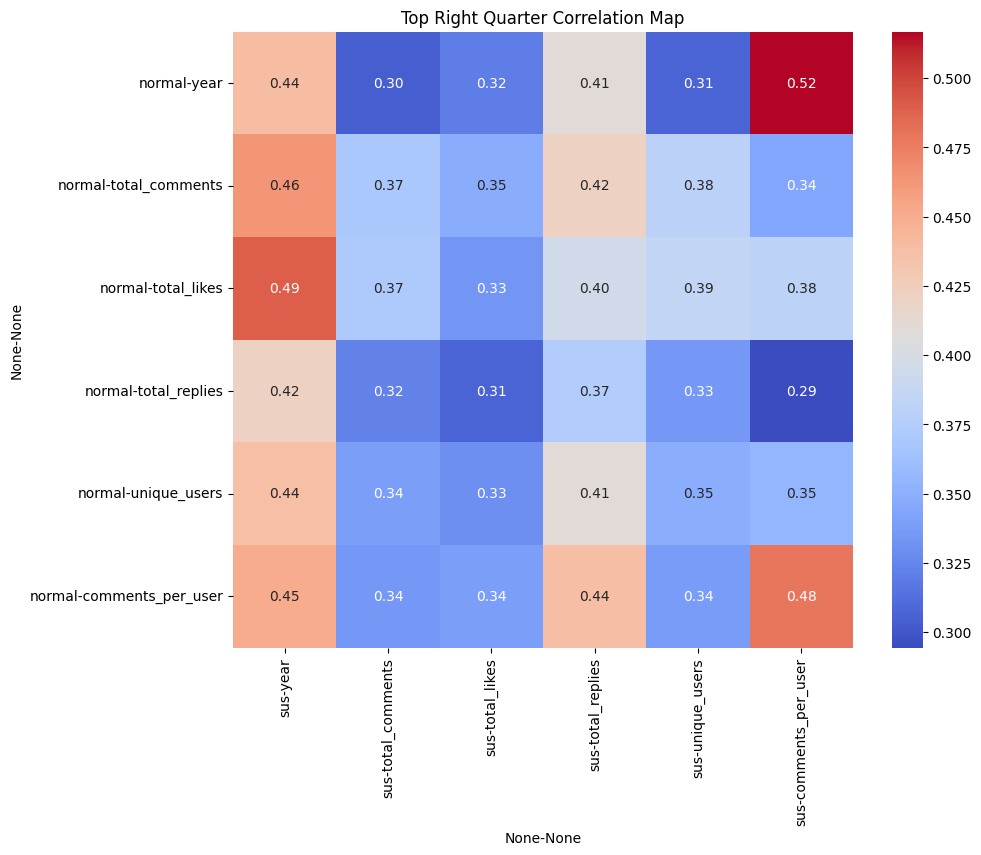

In [15]:
# Convert Polars DataFrames to Pandas DataFrames
df1_pd = final_result.to_pandas()
df2_pd = final_result_sus.to_pandas()

# Concatenate the two DataFrames
concatenated_df = pd.concat([df1_pd, df2_pd], axis=1, keys=["normal", "sus"])

# Compute the correlation matrix
correlation_matrix = concatenated_df.corr().abs()

# Get the number of columns
num_cols = len(correlation_matrix.columns)

# Slice the correlation matrix to get the top right quarter
top_right_quarter = correlation_matrix.iloc[:num_cols//2, num_cols//2:]

# Plot the sliced correlation matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(top_right_quarter, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Top Right Quarter Correlation Map")
plt.show()

In [17]:
final_result.with_columns()

shape: (15, 6)
┌──────┬────────────────┬─────────────┬───────────────┬──────────────┬───────────────────┐
│ year ┆ total_comments ┆ total_likes ┆ total_replies ┆ unique_users ┆ comments_per_user │
│ ---  ┆ ---            ┆ ---         ┆ ---           ┆ ---          ┆ ---               │
│ i32  ┆ u32            ┆ i64         ┆ i64           ┆ u32          ┆ f64               │
╞══════╪════════════════╪═════════════╪═══════════════╪══════════════╪═══════════════════╡
│ 2019 ┆ 1234962        ┆ 9460254     ┆ 464616        ┆ 304544       ┆ 4.055118          │
│ 2013 ┆ 332022         ┆ 626748      ┆ 51025         ┆ 115648       ┆ 2.870971          │
│ 2007 ┆ 11899          ┆ 31987       ┆ 2141          ┆ 7207         ┆ 1.651034          │
│ 2018 ┆ 1682310        ┆ 10897528    ┆ 639013        ┆ 397226       ┆ 4.235146          │
│ 2010 ┆ 71103          ┆ 98883       ┆ 6252          ┆ 33569        ┆ 2.118115          │
│ …    ┆ …              ┆ …           ┆ …             ┆ …            ┆ …                 │
│ 2009 ┆ 54829          ┆ 240496      ┆ 11205         ┆ 30948        ┆ 1.771649          │
│ 2008 ┆ 21010          ┆ 37405       ┆ 2035          ┆ 11756        ┆ 1.787173          │
│ 2005 ┆ 629            ┆ 226         ┆ 66            ┆ 522          ┆ 1.204981          │
│ 2015 ┆ 548054         ┆ 2479421     ┆ 245205        ┆ 185648       ┆ 2.952114          │
│ 2011 ┆ 149821         ┆ 233195      ┆ 12839         ┆ 56368        ┆ 2.657909          │
└──────┴────────────────┴─────────────┴───────────────┴──────────────┴───────────────────┘

In [18]:

# Convert the 'year' column to a date type (assuming the 'year' contains year only, adjust if needed)
df = final_result.with_columns(pl.col("year").cast(pl.Utf8).str.strptime(pl.Date, "%Y"))

# Extract the 'year' column as a pandas DataFrame
date_column = df.select("year").to_pandas()

# Drop the 'year' column from the DataFrame for scaling
df_without_date = df.drop("year").to_pandas()

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
scaled_array = scaler.fit_transform(df_without_date)

# Convert the scaled array back to a Pandas DataFrame
scaled_df_pd = pd.DataFrame(scaled_array, columns=df_without_date.columns)

# Add the 'year' column back to the scaled DataFrame
scaled_df_pd["year"] = date_column

# Convert the Pandas DataFrame back to a Polars DataFrame
scaled_df = pl.DataFrame(scaled_df_pd)

# Print the result
print(scaled_df)

shape: (15, 6)
┌────────────────┬─────────────┬───────────────┬──────────────┬─────────────────────┬──────────────┐
│ total_comments ┆ total_likes ┆ total_replies ┆ unique_users ┆ comments_per_user   ┆ year         │
│ ---            ┆ ---         ┆ ---           ┆ ---          ┆ ---                 ┆ ---          │
│ f64            ┆ f64         ┆ f64           ┆ f64          ┆ f64                 ┆ datetime[ms] │
╞════════════════╪═════════════╪═══════════════╪══════════════╪═════════════════════╪══════════════╡
│ 0.733988       ┆ 0.868107    ┆ 0.727056      ┆ 0.76637      ┆ 0.940588            ┆ 2019-01-01   │
│                ┆             ┆               ┆              ┆                     ┆ 00:00:00     │
│ 0.197061       ┆ 0.057493    ┆ 0.079755      ┆ 0.290206     ┆ 0.549802            ┆ 2013-01-01   │
│                ┆             ┆               ┆              ┆                     ┆ 00:00:00     │
│ 0.006702       ┆ 0.002915    ┆ 0.003248      ┆ 0.016851     ┆ 0.147204    

In [20]:
# Convert the 'year' column to a date type (assuming the 'year' contains year only, adjust if needed)
final_result = scaled_df.sort('year')
df = final_result_sus.with_columns(pl.col("year").cast(pl.Utf8).str.strptime(pl.Date, "%Y"))

# Extract the 'year' column as a pandas DataFrame
date_column = df.select("year").to_pandas()

# Drop the 'year' column from the DataFrame for scaling
df_without_date = df.drop("year").to_pandas()

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
scaled_array = scaler.fit_transform(df_without_date)

# Convert the scaled array back to a Pandas DataFrame
scaled_df_pd = pd.DataFrame(scaled_array, columns=df_without_date.columns)

# Add the 'year' column back to the scaled DataFrame
scaled_df_pd["year"] = date_column

# Convert the Pandas DataFrame back to a Polars DataFrame
scaled_df = pl.DataFrame(scaled_df_pd)

# Print the result
print(scaled_df)

shape: (15, 6)
┌────────────────┬─────────────┬───────────────┬──────────────┬─────────────────────┬──────────────┐
│ total_comments ┆ total_likes ┆ total_replies ┆ unique_users ┆ comments_per_user   ┆ year         │
│ ---            ┆ ---         ┆ ---           ┆ ---          ┆ ---                 ┆ ---          │
│ f64            ┆ f64         ┆ f64           ┆ f64          ┆ f64                 ┆ datetime[ms] │
╞════════════════╪═════════════╪═══════════════╪══════════════╪═════════════════════╪══════════════╡
│ 0.0            ┆ 0.0         ┆ 0.0           ┆ 0.0          ┆ 0.0                 ┆ 2005-01-01   │
│                ┆             ┆               ┆              ┆                     ┆ 00:00:00     │
│ 0.001633       ┆ 0.000275    ┆ 0.000269      ┆ 0.002274     ┆ 0.422675            ┆ 2006-01-01   │
│                ┆             ┆               ┆              ┆                     ┆ 00:00:00     │
│ 0.012646       ┆ 0.001565    ┆ 0.002058      ┆ 0.011241     ┆ 1.0         

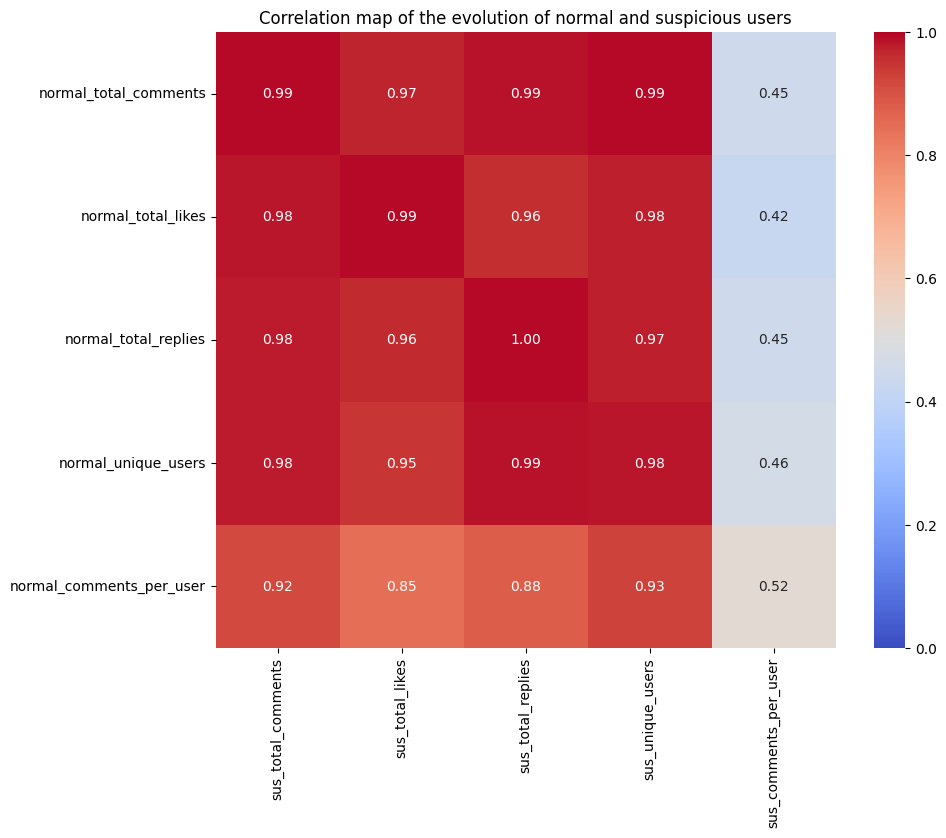

In [22]:
# Sory by year
final_result_sus = scaled_df.sort('year')

# Convert Polars df to Pandas df
df1_pd = final_result.to_pandas()
df2_pd = final_result_sus.to_pandas()

# Concatenate the two df
concatenated_df = pd.concat([df1_pd, df2_pd], axis=1, keys=["normal", "sus"])

# Reset index to flatten the hierarchical index
concatenated_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in concatenated_df.columns]

# Compute correlation matrix
correlation_matrix = concatenated_df.corr().abs()

# Get number of colmns
num_cols = len(correlation_matrix.columns)

# Slice corelation matrix to get the top right quarter
top_right_quarter = correlation_matrix.iloc[:num_cols//2-1, num_cols//2:-1]

# Plot sliced correlation matrix using Seabron
plt.figure(figsize=(10, 8))
sns.heatmap(top_right_quarter, annot=True, cmap='coolwarm', fmt='.2f', vmin=0, vmax=1)
plt.title("Correlation map of the evolution of normal and suspicious users")
plt.savefig('./images/corr_map_evol_normal_sus_T1.svg', bbox_inches='tight')
plt.show()

In [67]:
pio.templates.default = "plotly_white"

fig = go.Figure(data=go.Heatmap(
    z=top_right_quarter.values,
    x=top_right_quarter.columns,
    y=top_right_quarter.index,
    colorscale=px.colors.diverging.RdBu[::-1],
    zmin=0,
    zmax=1,
    text = top_right_quarter.round(2).values,
    texttemplate="%{text}", hovertemplate=None
))

fig.update_layout(
    xaxis_nticks=36,
    xaxis_title='Suspicious',
    yaxis_title='Normal' 
)
fig.write_html("./images/heatmap_norm_sus.html")
fig.show()

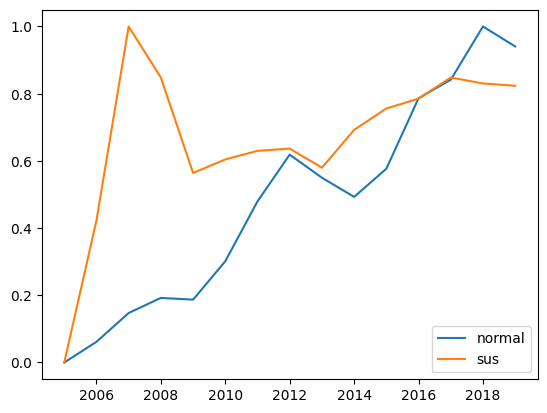

In [27]:
plt.plot(df1_pd['year'],df1_pd["comments_per_user"], label='normal')
plt.plot(df2_pd["year"],df2_pd["comments_per_user"], label= 'sus')
plt.legend()

# Intersection of Both Types of Suspicious Users

In [2]:
dataset = 'suspicious'

print(f"reading partial files '{dataset}_i.parquet'...")

# List all Parquet files
parquet_files_type_1 = glob.glob(f'./data/data_type1/{dataset}_*.parquet')
parquet_files_type_2 = glob.glob(f'./data/data_type2/{dataset}_*.parquet')

# Read and concatenate all author columns of Parquet files
authors_type_1 = pl.concat([pl.scan_parquet(file).select("author").collect() 
                            for file in parquet_files_type_1]).unique()

authors_type_2 = pl.concat([pl.scan_parquet(file).select('author').unique()
                            for file in parquet_files_type_2])

reading partial files 'suspicious_i.parquet'...


Type 2 is too big to be collected entirely thys it will only be read by chunks

In [4]:
len_type_2 = pl.concat([pl.scan_parquet(file).select('author').unique().select(pl.len()).collect() for file in parquet_files_type_2]).sum()
len_type_2 = len_type_2.item()
print(f"The length of authors_type_2 is : {len_type_2}")

The length of authors_type_2 is : 3845594


In [5]:
chunk_size = 1_000_000

# Setting the DF for both type of suspicious accounts
authors_1_2 = pl.DataFrame()

for start in tqdm(range(0, len_type_2, chunk_size), desc="Processing chunks"):

    chunk = authors_type_2.slice(start, chunk_size).collect()

	# Only keeping the unique ID to save RAM
    joined_chunk = authors_type_1.join(chunk, on="author", how="inner").unique()

    authors_1_2 = pl.concat([authors_1_2, joined_chunk])

Processing chunks:   0%|          | 0/4 [00:00<?, ?it/s]

Processing chunks: 100%|██████████| 4/4 [02:04<00:00, 31.06s/it]


In [8]:
# To ensure that the dataframe only holds unique author id
authors_1_2 = authors_1_2.unique()
authors_1_2.write_parquet("./data/intersection/suspicious_users_1_2.parquet")
authors_1_2 = pl.read_parquet("./data/intersection/suspicious_users_1_2.parquet")

len_type_2 = 3845594
len_type_1 = len(authors_type_1.unique())
len_1_2 = len(authors_1_2)

print(f"Ratio of users in type 1 : {len_1_2/len_type_1*100}")
print(f"Ratio of users in type 2 : {len_1_2/len_type_2*100}")

Ratio of users in type 1 : 53.8304711885226
Ratio of users in type 2 : 76.53493842563724


In [11]:
# Extracting the unique type 2 accounts
authors_1_2_date = authors_type_1.join(other=authors_1_2, on="author", how="inner")
authors_1_excl = authors_type_1.join(other=authors_1_2, on="author", how="anti")

chunk_size = 1_000_000

# Setting the DF for both type of suspicious accounts
authors_2_excl = pl.DataFrame()

for start in tqdm(range(0, len_type_2, chunk_size), desc="Processing chunks"):

    chunk = authors_type_2.slice(start, chunk_size).collect()

	# Only keeping the authors that are only type 2
    anti_joined_chunk = chunk.join(other=authors_1_2, on="author", how="anti")

    authors_2_excl = pl.concat([authors_2_excl, anti_joined_chunk])

Processing chunks: 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]


Now it is time to convert the authors to value counts.

In [12]:
authors_1_excl = authors_1_excl.with_columns([
    pl.col("upload_date").dt.year().alias("year"),
    pl.col("upload_date").dt.month().alias("month")
])

authors_2_excl = authors_2_excl.with_columns([
    pl.col("upload_date").dt.year().alias("year"),
    pl.col("upload_date").dt.month().alias("month")
])

authors_1_2_date = authors_1_2_date.with_columns([
    pl.col("upload_date").dt.year().alias("year"),
    pl.col("upload_date").dt.month().alias("month")
])

In [13]:
# Group by year and month and sum the values
authors_1_excl = authors_1_excl.group_by(["year", "month"]).agg([
    pl.count()
])

authors_2_excl = authors_2_excl.group_by(["year", "month"]).agg([
    pl.count()
])

authors_1_2_date = authors_1_2_date.group_by(["year", "month"]).agg([
    pl.count()
])

/tmp/ipykernel_15184/2981079933.py:3: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count()
/tmp/ipykernel_15184/2981079933.py:7: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count()
/tmp/ipykernel_15184/2981079933.py:11: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count()


In [14]:
# Replacing the columns year month by a unique datetime column
authors_1_excl = authors_1_excl.with_columns([
    (pl.col("year") * 100 + pl.col("month")).cast(pl.Utf8).alias("year_month")
]).sort("year_month")

authors_2_excl = authors_2_excl.with_columns([
    (pl.col("year") * 100 + pl.col("month")).cast(pl.Utf8).alias("year_month")
]).sort("year_month")

authors_1_2_date = authors_1_2_date.with_columns([
    (pl.col("year") * 100 + pl.col("month")).cast(pl.Utf8).alias("year_month")
]).sort("year_month")

In [15]:
# dropping the useless columns
authors_1_excl = authors_1_excl.drop(["year",'month'])
authors_2_excl = authors_2_excl.drop(["year",'month'])
authors_1_2_date = authors_1_2_date.drop(["year",'month'])

In [16]:
# Converting pandas
authors_1_excl = authors_1_excl.to_pandas()
authors_2_excl = authors_2_excl.to_pandas()
authors_1_2_date = authors_1_2_date.to_pandas()

In [17]:
# Convert 'year_month' to datetime format
authors_1_excl['year_month'] = authors_1_excl['year_month'].apply(lambda x: datetime.strptime(x, "%Y%m"))
authors_2_excl['year_month'] = authors_2_excl['year_month'].apply(lambda x: datetime.strptime(x, "%Y%m"))
authors_1_2_date['year_month'] = authors_1_2_date['year_month'].apply(lambda x: datetime.strptime(x, "%Y%m"))

In [19]:
# Set index and rename cols
authors_1_excl = authors_1_excl.set_index('year_month')
authors_2_excl = authors_2_excl.set_index('year_month')
authors_1_2_date = authors_1_2_date.set_index('year_month')

authors_1_excl = authors_1_excl.rename(columns={"count":'authors_1_excl'})
authors_2_excl = authors_2_excl.rename(columns={"count":'authors_2_excl'})
authors_1_2_date = authors_1_2_date.rename(columns={"count":'authors_1_2'})

In [20]:
# Creating a new df for the stacked area plot | Deleting last month because not complete
authors_evol_df = pd.concat([authors_1_excl,authors_2_excl,authors_1_2_date], axis=1).fillna(0)[:-1]

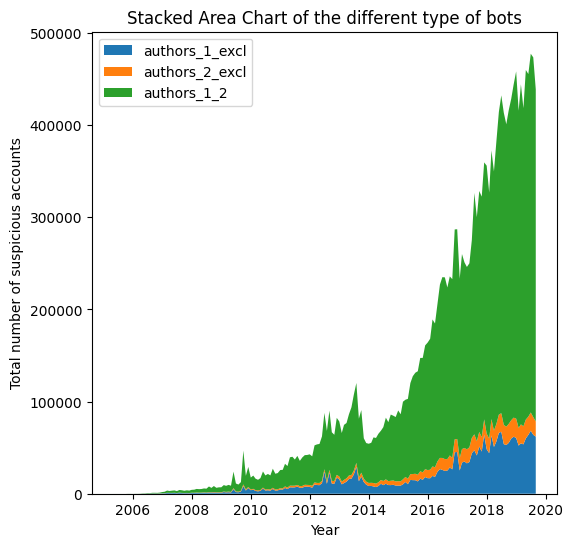

In [21]:
# Plot the stacked area chart with smoothing and custom colors
plt.figure(figsize=(6, 6))  # Set the figure size
plt.stackplot(authors_evol_df.index,
              authors_evol_df.values.T,
              labels=authors_evol_df.columns)
plt.xlabel('Year') # Add a label for the x-axis
plt.ylabel('Total number of suspicious accounts') # Add a label for the y-axis
plt.title('Stacked Area Chart of the different type of bots') # Add a title
plt.legend(loc='upper left') # Add a legend in the upper left corner of the plot

# Show the plot
plt.show()

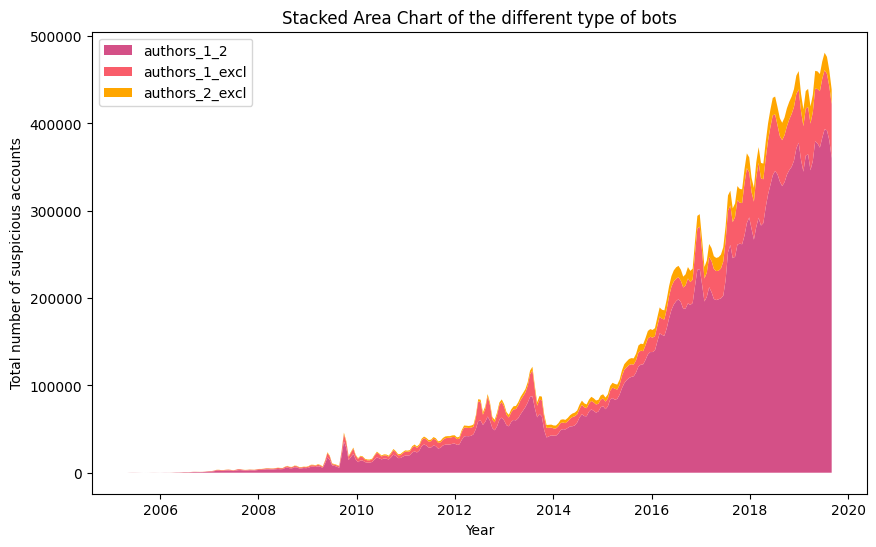

In [22]:
# Plot Growth of both types of bots

# Define custom colors
custom_colors = ["#003f5c","#2f4b7c","#665191","#a05195","#d45087","#f95d6a","#ff7c43","#ffa600"]
custom_colors = ["#d45087","#f95d6a","#ffa600"]
desired_order = ["authors_1_2", "authors_1_excl", "authors_2_excl"]

authors_evol_df = authors_evol_df[desired_order]
x_numeric = authors_evol_df.index.astype(np.int64)

# Smooth the lines using spline interpolation
x_smooth_numeric = np.linspace(x_numeric.min(), x_numeric.max(), 300)
pivot_smooth = pd.DataFrame({author_type: make_interp_spline(x_numeric, authors_evol_df[author_type])(x_smooth_numeric)
                             for author_type in authors_evol_df.columns})

# Convert the smoothed numeric values back to datetime
x_smooth = pd.to_datetime(x_smooth_numeric)

# Plot the stacked area chart with smoothing and custom colors
plt.figure(figsize=(10, 6))  # Set the figure size
plt.stackplot(x_smooth,
              pivot_smooth.values.T,
              labels=pivot_smooth.columns,
              colors=custom_colors)
plt.xlabel('Year') # Add a label for the x-axis
plt.ylabel('Total number of suspicious accounts') # Add a label for the y-axis
plt.title('Stacked Area Chart of the different type of bots') # Add a title
plt.legend(loc='upper left') # Add a legend in the upper left corner of the plot

# Show the plot
plt.show()

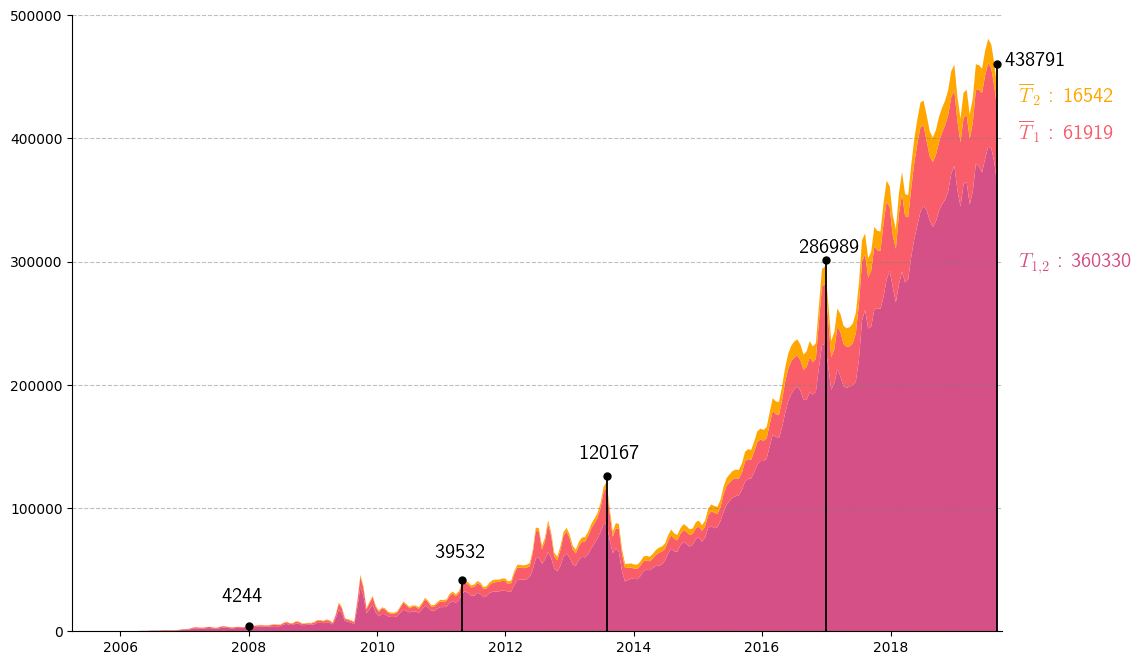

In [29]:
# Plot Growth of both types of bots

# Define custom colors for the countries
custom_colors = ["#d45087", "#f95d6a", "#ffa600"]

# Define desired order of countries
desired_order = ["authors_1_2", "authors_1_excl", "authors_2_excl"]

# Reorder columns of the pivot_df and custom_colors list
authors_evol_df = authors_evol_df[desired_order]

# Convert datetime index to numeric values
x_numeric = authors_evol_df.index.astype(np.int64)

# Smooth the lines using spline interpolation
x_smooth_numeric = np.linspace(x_numeric.min(), x_numeric.max(), 300)
pivot_smooth = pd.DataFrame({author_type: make_interp_spline(x_numeric, authors_evol_df[author_type])(x_smooth_numeric)
                             for author_type in authors_evol_df.columns})

# Convert the smoothed numeric values back to datetime
x_smooth = pd.to_datetime(x_smooth_numeric)

# Getting the limits
start_time =authors_evol_df.index[0] - pd.Timedelta(weeks=4)
end_time = authors_evol_df.index[-1] +  pd.Timedelta(weeks=4)

# Plot the stacked area chart with smoothing and custom colors
plt.figure(figsize=(12, 8))  # Set the figure size
plt.stackplot(x_smooth, pivot_smooth.values.T, labels=pivot_smooth.columns, colors=custom_colors)

plt.rcParams['text.usetex'] = True
ax = plt.gca()

# Annotations for the values per year
def add_annotations_year(date):

    # Calculate total amount of wealth at a given year
    y_end = int(authors_evol_df.loc[date].sum())
    
    # Special case for 2021: we put it on the left instead of upper the line
    if date==authors_evol_df.index[-1]:
        date_text = date + pd.Timedelta(weeks=6)
        modif_yaxis = 20000
    else:
        date_text = date - pd.Timedelta(weeks=22)
        modif_yaxis = 20000
    
    # Add the values, with a specific position, in bold, black and a fontsize of 10
    plt.text(date_text,
             y_end+modif_yaxis,
             f'{y_end}',
             fontsize=15,
             color='black',
             fontweight = 'bold')
    
    # Add line 
    ax.plot([date, date], # x-axis position
            [0, y_end*1.05], # y-axis position (*1.05 is used to make a it little bit longer)
            color='black', # Color
            linewidth=1.3) # Width of the line
    
    # Add a point at the top of the line
    ax.plot(date, # x-axis position
            y_end*1.05, # y-axis position (*1.05 is used to make a it little bit longer)
            marker='o', # Style of the point
            markersize=5, # Size of the point
            color='black') # Color

# Add the line and the values for each of the following years
for date in ['2008-01-01', '2011-05-01','2013-08-01','2017-01-01','2019-09-01']:
    add_annotations_year(pd.Timestamp(date))
    

# Annotations for the values per node
def add_annotations(node, value_placement, amount, color):
    plt.text(pd.Timestamp('2020-01-01'), value_placement, f'{node} : {amount}', fontsize=15, color=color, fontweight='bold')

# We manually define the labels, values and position that will be displayed on the right of the graph
countries = [r'$\overline{T}_2$', r'$\overline{T}_1$', r"$T_{1,2}$"]
values_placement = [430000, 400000, 295000]
amounts = [int(authors_evol_df["authors_2_excl"][-1]), int(authors_evol_df["authors_1_excl"][-1]),
            int(authors_evol_df["authors_1_2"][-1])]
custom_colors.reverse()

# Iterate over all countries and add the name with the right value and color
for node, value, amount, color in zip(countries, values_placement, amounts, custom_colors):
    add_annotations(node, value, amount, color)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(axis="y", zorder=-2, linestyle='--', color='gray', alpha=0.5) 
plt.xlim(start_time, end_time)
plt.ylim(0, 500000)
plt.savefig("./images/different_types_of_bots.svg", bbox_inches='tight')
plt.show()